# Тестовое задание для стажеров в команду Data Science IDP

## Задание — написать решение по извлечению сущностей из документов (новостных текстов). Выполните задание в Jupyter Notebook. Ожидаемый результат: ipynb-файл с решением и всеми выводами ячеек, csv-файл с предсказаниями модели залитый в репоизторий на github.



В качестве датасета возьмите русские новости из Balto-Slavic Natural Language Processing 2019 (helsinki.fi). Интересующие сущности: PER, ORG, LOC, EVT, PRO (см. Guidelines_20190122.pdf (helsinki.fi)).

Достаточно использовать 9 документов про брекзит из предложенного организаторами семпла.


Пример одного документа:

ru-10

ru

2018-09-20

https://rg.ru/2018/09/20/tereza-mej-rasschityvaet-usidet-v-sedle-do-zaversheniia-procedury-brexit.html

Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit
Тем не менее, по сведениям британских СМИ, на предстоящей в конце сентября конференции партии тори противники Мэй навяжут ей серьезный бой, из которого не факт, что она выйдет победителем. Фаворит букмекеров в качестве возможного сменщика нынешнего премьера, бывший министр иностранных дел Британии Борис Джонсон намерен выступить с альтернативным докладом, который не оставит камня на камне от взглядов главы правительства на условия "брекзита". С точки зрения Джонсона, "Лондон обернул британскую конституцию поясом смертника и вручил детонатор Мишелю Барнье (главному переговорщику Брюсселя по "брекзиту". - От ред.)". С этой метафорой и предстоит сражаться на конференции главе правительства Альбиона.


Ответы на эти задания я делал и давал благодаря моему конспекту по основам машинного обучения ВШЭ https://colab.research.google.com/drive/1qvs5l247T8wbAR4tH3iKToKXuToFo1pI?usp=sharing

А также благодаря ДЗ-3 на курсе Математические методы анализа данных ПИ ВШЭ
https://github.com/HackerAizen/ML_HSE/blob/main/HW3/Dymov_HW3_FinalReadyLongworkingVersion.ipynb

Поэтому спасибо Вам за такую возможность попрактиковаться

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

Mounted at /content/drive


### Задание 1
Опишите задачу с точки зрения NLP. Что это за задача, какие классические методы существуют для ее решения? Как ее можно решать через LLM? Как обычно оценивают качество моделей в этой задаче?


#### Ответ:
Решается задача классификации, а именно выявление и извлечение именнованных сущностей из текста (NER), классификация этих сущностей.

Для решения данной задачи могут подойти (из классических методов):
- Регулярные выражения и словари (Rule-based)
- Из статистических Conditional Random Fields или Hidden Markov Models (как нам упоминала Тихонова Мария, Senior NLP DS Сбера, на лекциях по ОМО)
- Из ML подходов можно выделить: Support Vector Machine (SVM) и Случайный лес с фичами (Random Forest)

Решения через Large Language Model:
- Промпт-инжиниринг/Prompt engineering
- Fine Tuning моделей и FSL (few-shot learning)

Так как это задача классификации, то требуется измерять по метрикам классификации:
- Precision (точность), Recall (полнота), F1-score, ROC-AUC а также их гибриды (F-мера и гармоническое среднее)
- Можно еще использовать матрицу ошибок (Confusion Matrix)
- Micro, macro and weighted averaging (макро полезно на несбалансированных данных (accuracy плохо ведет себя на несбалансированных ибо нарушается баланс классов), а микро подойдет для повышения общей производительности)
- Exact и partial matches (https://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/)
- Возможно, еще есть варианты, но я их не помню или не знаю :(

### Задание 2
Реализуйте чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer". Выведите шапку датафрейма.


In [2]:
import os
import re
import pathlib

In [3]:
os.chdir("/content/drive/My Drive/")
raw_dir = './sample_pl_cs_ru_bg/raw/ru'
annotated_dir = './sample_pl_cs_ru_bg/annotated/ru'

In [4]:
dataset_raw = os.listdir(raw_dir)
dataset_annotated = os.listdir(annotated_dir)
sent = {}
for file in dataset_raw:
  if (re.match('.*\.txt', file)):
    filenew = open(raw_dir + '/' + file, 'r')
    all_lines = list(filter(None, list(filenew.read().splitlines())))
    # all_lines = list(filenew.readlines())
    # так можно сделать поскольку в датасете русских новостей есть
    # дата создания везде, URL, дата создания со временем и титульников через :
    # следовательно тупо можно удалить оставив только document_id и document_text
    del all_lines[1:5]
    # print(all_lines)
    document_entity = [all_lines[0]] + [" ".join(all_lines[1:])]
    # print(len(document_entity))
    # entity = {"document_id": document_entity[0], "document_text": document_entity[1]}
    # sent.append(entity)
    sent[document_entity[0]] = document_entity[1]

# df_pred = pd.DataFrame(data=sent, columns=['document_id', 'document_text'])
sent
# df_pred

<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-3598700604.py:5: SyntaxWarning: invalid escape sequence '\.'
  if (re.match('.*\.txt', file)):


{'ru-10': 'Тем не менее, по сведениям британских СМИ, на предстоящей в конце сентября конференции партии тори противники Мэй навяжут ей серьезный бой, из которого не факт, что она выйдет победителем. Фаворит букмекеров в качестве возможного сменщика нынешнего премьера, бывший министр иностранных дел Британии Борис Джонсон намерен выступить с альтернативным докладом, который не оставит камня на камне от взглядов главы правительства на условия "брекзита". С точки зрения Джонсона, "Лондон обернул британскую конституцию поясом смертника и вручил детонатор Мишелю Барнье (главному переговорщику Брюсселя по "брекзиту". - От ред.)". С этой метафорой и предстоит сражаться на конференции главе правительства Альбиона. Ради будущего торгового договора с единой Европой Лондон действительно согласился на множество уступок. Во-первых, он заплатит Брюсселю 39 миллиардов фунтов стерлингов. Во-вторых, будет выполнять законы ЕС. И, наконец, самое неприятное - от Британии требуют, чтобы она оставила Север

In [5]:
special_sent = {}
for file in dataset_annotated:
  if (re.match('.*\.out', file)):
    filenew = open(annotated_dir + '/' + file, 'r')
    all_lines = list(filenew.read().splitlines())

    funci = lambda der: der.split('\t')
    all_lines = list(map(funci, all_lines))
    all_lines = [str(all_lines[0][0])] + all_lines[1:]
    special_sent[all_lines[0]] = all_lines[1:]

    # print(all_lines)
special_sent

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1520195841.py:3: SyntaxWarning: invalid escape sequence '\.'
  if (re.match('.*\.out', file)):


{'ru-10': [['Brexit', 'Brexit', 'EVT', 'EVT-Brexit'],
  ['Альбиона', 'Альбион', 'LOC', 'GPE-Great-Britain'],
  ['Альбионе', 'Альбион', 'LOC', 'GPE-Great-Britain'],
  ['Борис Джонсон', 'Борис Джонсон', 'PER', 'PER-Boris-Johnson'],
  ['Британии', 'Британия', 'LOC', 'GPE-Great-Britain'],
  ['Британия', 'Британия', 'LOC', 'GPE-Great-Britain'],
  ['Брюсселе', 'Брюссель', 'LOC', 'GPE-Brussles'],
  ['Брюсселем', 'Брюссель', 'LOC', 'GPE-Brussles'],
  ['Брюссель', 'Брюссель', 'LOC', 'GPE-Brussles'],
  ['Брюсселю', 'Брюссель', 'LOC', 'GPE-Brussles'],
  ['Брюсселя', 'Брюссель', 'LOC', 'GPE-Brussles'],
  ['Джонсон', 'Джонсон', 'PER', 'PER-Boris-Johnson'],
  ['Джонсона', 'Джонсон', 'PER', 'PER-Boris-Johnson'],
  ['ЕС', 'ЕС', 'ORG', 'ORG-European-Union'],
  ['Еврокомиссия', 'Еврокомиссия', 'ORG', 'ORG-European-Commission'],
  ['Европа', 'Европа', 'LOC', 'LOC-Europe'],
  ['Европе', 'Европа', 'LOC', 'LOC-Europe'],
  ['Европейскому', 'Европейский', 'ORG', 'ORG-European-Parlament'],
  ['Европой', 'Европ

In [6]:
# Пока я делал дальше задания (перед 4 заданием), понял, что я сделал 2 задание
# не до конца. Нужно брать уникальные cross-lingual ID, чтобы не было потом повторяющихся
# промптов по различным формам одной и той же сущности. Легендарно переделываю

In [7]:
from collections import Counter, defaultdict

# Сначала соберем общую статистику по всем документам
global_cross_lingual_stats = defaultdict(lambda: {
    'category': None,
    'all_forms': set(),
    'base_form_counter': Counter()
})

# Проходим по всем документам и собираем общую статистику
for doc_id, entities in special_sent.items():
    for entity in entities:
        cross_lingual_id = entity[3]
        category = entity[2]

        # Определяем base_form для подсчета
        base_form = entity[1] if entity[1] != '' else entity[0]

        # Обновляем категорию (берем первую встреченную)
        if global_cross_lingual_stats[cross_lingual_id]['category'] is None:
            global_cross_lingual_stats[cross_lingual_id]['category'] = category

        # Добавляем формы
        if entity[0] != '':
            global_cross_lingual_stats[cross_lingual_id]['all_forms'].add(entity[0])
        if entity[1] != '':
            global_cross_lingual_stats[cross_lingual_id]['all_forms'].add(entity[1])

        # Считаем base_form (только если не пустая)
        if base_form != '':
            global_cross_lingual_stats[cross_lingual_id]['base_form_counter'][base_form] += 1

# Определяем golden_key для каждого cross-lingual ID на основе всей статистики
global_golden_keys = {}
for cross_id, stats in global_cross_lingual_stats.items():
    if stats['base_form_counter']:
        global_golden_keys[cross_id] = stats['base_form_counter'].most_common(1)[0][0]
    else:
        global_golden_keys[cross_id] = ''

# Теперь создаем финальную структуру для каждого документа
new_special_sentences = dict()

for doc_id, entities in special_sent.items():
    doc_dict = dict()

    for entity in entities:
        cross_lingual_id = entity[3]

        # Пропускаем если уже обработали этот ID в текущем документе
        if cross_lingual_id in doc_dict:
            continue

        # Собираем все формы для этого cross_lingual_id в текущем документе
        doc_forms = set()
        for doc_entity in entities:
            if doc_entity[3] == cross_lingual_id:
                if doc_entity[0] != '':
                    doc_forms.add(doc_entity[0])
                if doc_entity[1] != '':
                    doc_forms.add(doc_entity[1])

        # Используем глобальные данные для категории и golden_key
        doc_dict[cross_lingual_id] = {
            'category': global_cross_lingual_stats[cross_lingual_id]['category'],
            'golden_key': global_golden_keys[cross_lingual_id],
            'forms': doc_forms
        }

    new_special_sentences[doc_id] = doc_dict

# Проверяем результат
print("Общая статистика по cross-lingual ID:")
for cross_id in list(global_golden_keys.keys()):
    print(f"  {cross_id}:")
    print(f"    Category: {global_cross_lingual_stats[cross_id]['category']}")
    print(f"    Golden key: {global_golden_keys[cross_id]}")
    print(f"    Все формы: {list(global_cross_lingual_stats[cross_id]['all_forms'])}")
    print()

for cross_id, info in list(new_special_sentences.items()):
    print(f"  {cross_id}: {info}")

Общая статистика по cross-lingual ID:
  EVT-Brexit:
    Category: EVT
    Golden key: Brexit
    Все формы: ['брексит', 'Брекзит', 'Brexit', 'брекзиту', 'брекзита', 'брекзит']

  GPE-Great-Britain:
    Category: LOC
    Golden key: Великобритания
    Все формы: ['Британия', 'Альбион', 'Британии', 'Великобритания', 'Великобритании', 'Альбионе', 'Соединенное Королевство', 'Великобританией', 'Соединенного Королевства', 'Альбиона']

  PER-Boris-Johnson:
    Category: PER
    Golden key: Борис Джонсон
    Все формы: ['Борисом Джонсоном', 'Бориса Джонсона', 'Джонсоном', 'Бориса', 'Джонсона', 'Борис Джонсон', 'Джонсон', 'Борис']

  GPE-Brussles:
    Category: LOC
    Golden key: Брюссель
    Все формы: ['Брюссель', 'Брюсселю', 'Брюсселем', 'Брюсселе', 'Брюсселя']

  ORG-European-Union:
    Category: ORG
    Golden key: ЕС
    Все формы: ['ЕС', 'Евросоюз', 'Евросоюза', 'Евросоюзом']

  ORG-European-Commission:
    Category: ORG
    Golden key: Еврокомиссия
    Все формы: ['Еврокомиссия']

  LO

In [8]:

def create_clean_dataframe(sent_dict, special_sent_dict, new_special_sentences):
    """
    Чистая версия DataFrame только с обязательными колонками
    """
    rows = []

    for doc_id, entities_list in special_sent_dict.items():
        if doc_id not in sent_dict:
            continue

        doc_text = sent_dict[doc_id]

        for entity_data in entities_list:
            if len(entity_data) >= 4 and entity_data[0]:  # Проверяем named_entity
                cross_lingual_id = entity_data[3]

                # Получаем данные из new_special_sentences
                if (doc_id in new_special_sentences and
                    cross_lingual_id in new_special_sentences[doc_id]):

                    category = new_special_sentences[doc_id][cross_lingual_id]['category']
                    gold_answer = new_special_sentences[doc_id][cross_lingual_id]['golden_key']

                    # Fallback если golden_key пустой
                    if not gold_answer:
                        gold_answer = entity_data[0]
                else:
                    # Fallback на случай проблем
                    category = entity_data[2]
                    gold_answer = entity_data[0]

                rows.append({
                    "document_id": doc_id,
                    "document_text": doc_text,
                    "entity": category,
                    "gold_answer": gold_answer
                })

    df = pd.DataFrame(rows)


    return df

# Создаем чистый DataFrame
print("DataFrame создан! Я этооооо сделааааал")
df_clean = create_clean_dataframe(sent, special_sent, new_special_sentences)
df_cleaned = df_clean.drop_duplicates()
df_cleaned['document_id'].nunique()
df_cleaned.head()
df_cleaned.to_csv('bobo_dataset.csv', index=False, encoding='utf-8')


DataFrame создан! Я этооооо сделааааал


In [9]:
def create_final_dataframe(sent_dict, special_sent_dict):
    rows = []

    for doc_id, entities_list in special_sent_dict.items():
        if doc_id not in sent_dict:
            print(f"Пропущен документ {doc_id} - нет текста. Работай больше")
            continue

        doc_text = sent_dict[doc_id]

        for entity_data in entities_list:
            if len(entity_data) >= 3:
                rows.append({
                    "document_id": doc_id,
                    "document_text": doc_text,
                    "entity": entity_data[2],  # category
                    "gold_answer": entity_data[0]  # Named-entity-mention
                })

    df = pd.DataFrame(rows)

    # Статистика
    print("DataFrame создан! Я этооооо сделааааал")

    print(f"Колмчество строк: {len(df)}")
    print(f"Документов прочитано: {df['document_id'].nunique()}")
    print(f"Типов сущностей отмечено: {df['entity'].nunique()}")
    print(f"Распределение сущностей:")
    for entity_type, count in df['entity'].value_counts().items():
        print(f"     {entity_type}: {count}")

    return df

# Создаем финальный DataFrame
dfffff = create_final_dataframe(sent, special_sent)
dfffff = dfffff.drop_duplicates()
dfffff.to_csv('dataset_with_answers_for_only_onedoc.csv', index=False, encoding='utf-8')
dfffff.head()

DataFrame создан! Я этооооо сделааааал
Колмчество строк: 153
Документов прочитано: 9
Типов сущностей отмечено: 5
Распределение сущностей:
     PER: 63
     ORG: 36
     LOC: 36
     EVT: 13
     PRO: 5


,document_id,document_text,entity,gold_answer
0,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",EVT,Brexit
1,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",LOC,Альбиона
2,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",LOC,Альбионе
3,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",PER,Борис Джонсон
4,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",LOC,Британии


In [10]:
df_cleaned.head()

,document_id,document_text,entity,gold_answer
0,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",EVT,Brexit
1,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",LOC,Великобритания
3,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",PER,Борис Джонсон
6,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",LOC,Брюссель
13,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",ORG,ЕС


### Задание 3
Напишите функцию, которая принимает на вход строку датафрейма и выдает текст входного сообщения для LLM.


In [11]:
def create_funcing_llm_prompt(row):
    entity_type = row['entity']
    document_text = row['document_text']

    # Примеры для модели, чтобы она поняла что требуют от нее
    examples = {
        'PER': "Имена людей. Примеры: 'Тереза Мэй', 'Борис Джонсон', 'Мария Захарова'",
        'ORG': "Организации, компании, учреждения. Примеры: 'ЕС', 'МИД России', 'The Guardian'",
        'LOC': "Географические локации, города, страны. Примеры: 'Лондон', 'Великобритания', 'Брюссель'",
        'EVT': "События, исторические моменты. Примеры: 'Brexit', 'брекзит'",
        'PRO': "Продукты, бренды, названия изданий. Примеры: 'Facebook', 'The Guardian'"
    }
    example = examples.get(entity_type, "")
    prompt = f"""
    Ты - эксперт по извлечению именованных сущностей из текстов.
    ЗАДАЧА: Извлеки все сущности типа **{entity_type}** из приведенного текста.
    {example}

    ТРЕБОВАНИЯ:
    1. Найди без исключения ВСЕ упоминания сущностей типа {entity_type}
    2. Сохрани их в той форме, в которой они встречаются в тексте
    3. Не изменяй написание и регистр
    4. Если сущностей нет - верни пустой список
    5. Не добавляй никаких комментариев или объяснений

    ТЕКСТ:
    {document_text}

    ФОРМАТ ОТВЕТА - ТОЛЬКО JSON без всяких дополнительных комментариев:
    {{"entities": ["сущность1", "сущность2", ...]}}
"""
    return prompt.strip()

def add_prompts_to_funcing_df(df_new):
    df_new['own_llm_prompt'] = df_new.apply(create_funcing_llm_prompt, axis=1)
    return df_new

new_df_with_own_prompts = add_prompts_to_funcing_df(df_cleaned.copy())
new_df_with_own_prompts.to_csv('dataset_own_prompts.csv', index=False, encoding='utf-8')
new_df_with_own_prompts
# test_rows = [
#     df[df['entity'] == 'PER'].iloc[0],  # Первая PERSON сущность
#     df[df['entity'] == 'ORG'].iloc[0],   # Первая ORGANIZATION сущность
#     df[df['entity'] == 'LOC'].iloc[0],   # Первая LOCATION сущность
#     df[df['entity'] == 'EVT'].iloc[0],   # Первая EVENT сущность
# ]

# for i, test_row in enumerate(test_rows, 1):
#     print("\n")
#     print(f"ТЕСТ {i}: Сущность типа '{test_row['entity']}'")
#     prompt = create_funcing_llm_prompt(test_row)
#     print(prompt)

#     # Показываем оригинальный gold_answer для сравнения
#     print(f"Ожидаемая сущность: '{test_row['gold_answer']}'")

,document_id,document_text,entity,gold_answer,own_llm_prompt
0,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",EVT,Brexit,Ты - эксперт по извлечению именованных сущност...
1,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",LOC,Великобритания,Ты - эксперт по извлечению именованных сущност...
3,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",PER,Борис Джонсон,Ты - эксперт по извлечению именованных сущност...
6,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",LOC,Брюссель,Ты - эксперт по извлечению именованных сущност...
13,ru-10,"Тем не менее, по сведениям британских СМИ, на ...",ORG,ЕС,Ты - эксперт по извлечению именованных сущност...
...,...,...,...,...,...
147,ru-1003,Об этом сообщает агентство Рейтер. Сегодня пре...,PER,Дэвид Дэвис,Ты - эксперт по извлечению именованных сущност...
148,ru-1003,Об этом сообщает агентство Рейтер. Сегодня пре...,ORG,ЕС,Ты - эксперт по извлечению именованных сущност...
149,ru-1003,Об этом сообщает агентство Рейтер. Сегодня пре...,PER,Тереза Мэй,Ты - эксперт по извлечению именованных сущност...
150,ru-1003,Об этом сообщает агентство Рейтер. Сегодня пре...,ORG,Рейтер,Ты - эксперт по извлечению именованных сущност...


Я на всякий случай создал оба варианта (где только самое ключевое и слова в базовой форме) и (где все слова по каждому документу в любом имени и регистре)

Двойная работа, но зато смогу с вами поообщаться о том, что возможно не так понял. Заодно позанимаюсь исследованием

### Задание 4
Получите ответы GigaChat для всех документов. Документов всего 9, поэтому сделать это можно вручную, пользуясь веб-интерфейсом GigaChat или ботом в ВК или Телеграме. Не очищайте историю сообщений, чтобы потом продемонстрировать подлинность ответов на онлайн-собеседовании.
Внесите ответы GigaChat в датафрейм, сохраните его.


In [12]:
# посмотрим на все созданные мои промпты и скопируем их в Gigachat
# удалить можно дупликаты по столбцу document_id, но не уверен что это требовалось
new_df_with_own_prompts['own_llm_prompt'].to_csv('dataset_own_prompts_only.csv', encoding='utf-8')

так как мне пришлось каждый промпт в отдельности загонять, то я буду дальше работать только с датасетом где всего 88 строк и возможно объединю те строки где одинаковые названия документов и при этом одинаковая категория в entity

In [13]:
new_df_with_own_prompts['document_id'].value_counts()

,count
document_id,
ru-10,18
ru-1004,12
ru-1017,11
ru-1000,11
ru-1011,8
ru-1003,8
ru-1006,7
ru-1001,7
ru-1002,6


In [14]:
result_dffff = new_df_with_own_prompts.groupby(['document_id', 'entity', 'document_text', 'own_llm_prompt'])['gold_answer'].agg(list).reset_index()
result_dffff

,document_id,entity,document_text,own_llm_prompt,gold_answer
0,ru-10,EVT,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,[Brexit]
1,ru-10,LOC,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,"[Великобритания, Брюссель, Европа, Ла-Манш, Ло..."
2,ru-10,ORG,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,"[ЕС, Еврокомиссия, Европейский, Консервативная..."
3,ru-10,PER,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,"[Борис Джонсон, Мишель Барнье, Тереза Мэй, Себ..."
4,ru-1000,EVT,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,[Brexit]
5,ru-1000,LOC,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,[Великобритания]
6,ru-1000,ORG,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,"[ЕС, МИД Соединенного Королевства, УНН]"
7,ru-1000,PER,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,"[Борис Джонсон, Дэвид Дэвис, Стив Бейкер, Тере..."
8,ru-1000,PRO,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,"[The Guardian, Подробности.ua]"
9,ru-1001,EVT,Министр иностранных дел Великобритании Борис Д...,Ты - эксперт по извлечению именованных сущност...,[Brexit]


In [15]:
result_dffff.shape

(40, 5)

In [16]:
result_dffff.to_csv('dataset_grouped_by_entities.csv', encoding='utf-8')

In [17]:
result_dffff['own_llm_prompt'].to_csv('dataset_prompts_grouped.csv', encoding='utf-8')

In [18]:
result_dffff['gold_answer']

,gold_answer
0,[Brexit]
1,"[Великобритания, Брюссель, Европа, Ла-Манш, Ло..."
2,"[ЕС, Еврокомиссия, Европейский, Консервативная..."
3,"[Борис Джонсон, Мишель Барнье, Тереза Мэй, Себ..."
4,[Brexit]
5,[Великобритания]
6,"[ЕС, МИД Соединенного Королевства, УНН]"
7,"[Борис Джонсон, Дэвид Дэвис, Стив Бейкер, Тере..."
8,"[The Guardian, Подробности.ua]"
9,[Brexit]


In [19]:
# Список словарей с сущностями

responses = [
    {"entities": ["брекзит"]},                # Ответ №0
    {"entities": ["Лондон", "Брюссель", "Северная Ирландия", "Альбион", "Европа", "Ла-Манш"]},  # Ответ №1
    {"entities": ["партии тори", "ЕС", "Брюссель", "Европой", "Британии", "британская конституция", "Брюссель", "Единая Европа", "таможенный союз единой Европы", "Конституционная партия", "Международный валютный фонд", "Еврокомиссия", "Европейский парламент", "британский парламент", "лейбористы", "консерваторы", "Евросоюз"]},  # Ответ №2
    {"entities": ["Мэй", "Борис Джонсон", "Джонсон", "Мишель Барнье", "Себастьян Курц"]},  # Ответ №3
    {"entities": ["Brexit", "brexit"]},               # Ответ №4
    {"entities": ["Великобритания", "Соединенное Королевство"]},  # Ответ №5
    {"entities": ["ЕС", "The Guardian", "УНН", "британский парламент"]},  # Ответ №6
    {"entities": ["Джонсон", "Дэвид Дэвис", "Стив Бейкер", "Тереза Мэй", "Борис Джонсон"]},  # Ответ №7
    {"entities": ["The Guardian", "УНН"]},   # Ответ №8
    {"entities": ["Brexit"]},               # Ответ №9
    {"entities": ["Великобритания", "Соединенное Королевство"]},  # Ответ №10
    {"entities": ["Associated Press", "ЕС"]},                    # Ответ №11
    {"entities": ["Тереза Мэй", "Борис Джонсон", "Борис"]},  # Ответ №12
    {"entities": ["Брекзит"]},              # Ответ №13
    {"entities": ["Великобритания"]},                 # Ответ №14
    {"entities": ["ЕС"]},                     # Ответ №15
    {"entities": ["Тереза Мэй", "Борис Джонсон", "Дэвид Дэвис"]},  # Ответ №16
    {"entities": ["Brexit"]},                # Ответ №17
    {"entities": ["Даунинг-Стрит", "Великобритания"]},  # Ответ №18
    {"entities": ["агентство Рейтер", "Даунинг-Стрит", "ЕС"]},  # Ответ №19
    {"entities": ["Тереза Мэй", "Джонсон", "Борис Джонсон", "Дэвид Дэвис"]},  # Ответ №20
    {"entities": ["Brexit", "Brexit"]},           # Ответ №21
    {"entities": ["Великобритания", "Германия", "Польша", "Лондон"]},  # Ответ №22
    {"entities": ["ТАСС", "ЕС", "Евросоюз", "Консервативная партия"]},  # Ответ №23
    {"entities": ["Борис Джонсон", "Тереза Мэй", "Дэвид Дэвис", "Джонсон"]},  # Ответ №24
    {"entities": ["Brexit"]},   # Ответ №25
    {"entities": ["России", "Великобритания"]},  # Ответ №26
    {"entities": ["МИД России", "Facebook"]},  # Ответ №27
    {"entities": ["Мария Захарова", "Борис Джонсон", "Т. Мэй"]},  # Ответ №28
    {"entities": ["Facebook"]},   # Ответ №29
    {"entities": ["Brexit"]},                # Ответ №30
    {"entities": ["Великобритания"]},          # Ответ №31
    {"entities": ["ЕС", "The Guardian", "Палата общин", "Евросоюз"]},                     # Ответ №32
    {"entities": ["Борис Джонсон", "Тереза Мэй", "Дэвид Дэвис"]},  # Ответ №33
    {"entities": ["The Guardian"]},           # Ответ №34
    {"entities": []},                                      # Ответ №35 (нет сущностей)
    {"entities": ["КИЕВ", "Великобритания", "ЕС", "Соединенное Королевство"]},  # Ответ №36
    {"entities": ["The Guardian", "британский парламент", "ЕС"]},  # Ответ №37
    {"entities": ["Борис Джонсон", "Дэвид Дэвис", "Стив Бейкер", "Тереза Мэй"]},  # Ответ №38
    {"entities": ["The Guardian", "УНН"]}    # Ответ №39
]

# Проверка количества словарей
print(f"Всего словарей в списке: {len(responses)}")

# Пример использования

Всего словарей в списке: 40


In [20]:
def add_gigachat_responses(df, responses):
    # Проверяем, что количество ответов совпадает с количеством строк
    if len(responses) != len(df):
        print(f"количество ответов ({len(responses)}) не совпадает с количеством строк датафрейма ({len(df)})")

    result_df = df.copy()


    # Добавляем колонку с извлеченными сущностями
    result_df['gigachat_entities'] = [response['entities'] for response in responses]

    return result_df

result_dffff_resp = add_gigachat_responses(result_dffff, responses)
result_dffff_resp

,document_id,entity,document_text,own_llm_prompt,gold_answer,gigachat_entities
0,ru-10,EVT,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,[Brexit],[брекзит]
1,ru-10,LOC,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,"[Великобритания, Брюссель, Европа, Ла-Манш, Ло...","[Лондон, Брюссель, Северная Ирландия, Альбион,..."
2,ru-10,ORG,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,"[ЕС, Еврокомиссия, Европейский, Консервативная...","[партии тори, ЕС, Брюссель, Европой, Британии,..."
3,ru-10,PER,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,"[Борис Джонсон, Мишель Барнье, Тереза Мэй, Себ...","[Мэй, Борис Джонсон, Джонсон, Мишель Барнье, С..."
4,ru-1000,EVT,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,[Brexit],"[Brexit, brexit]"
5,ru-1000,LOC,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,[Великобритания],"[Великобритания, Соединенное Королевство]"
6,ru-1000,ORG,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,"[ЕС, МИД Соединенного Королевства, УНН]","[ЕС, The Guardian, УНН, британский парламент]"
7,ru-1000,PER,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,"[Борис Джонсон, Дэвид Дэвис, Стив Бейкер, Тере...","[Джонсон, Дэвид Дэвис, Стив Бейкер, Тереза Мэй..."
8,ru-1000,PRO,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,"[The Guardian, Подробности.ua]","[The Guardian, УНН]"
9,ru-1001,EVT,Министр иностранных дел Великобритании Борис Д...,Ты - эксперт по извлечению именованных сущност...,[Brexit],[Brexit]


In [21]:
result_dffff_resp.to_csv('dataset_prompts_gigachattt_grouped.csv', encoding='utf-8')

### Задание 5
Реализуйте самостоятельно алгоритм для подсчета метрик score_fn(gold: str, pred: str) → float. Можно пользоваться только библиотеками numpy, scipy, pandas. Напишите юнит-тесты. Возможно ли ускорить вычисление функции через векторную реализацию? Поясните решение и обоснуйте, почему выбрали именно такую метрику.


In [22]:
from typing import Union

def score_fn(gold: Union[str, List[str]], pred: Union[str, List[str]]) -> float:
    """
    Вычисляет score между gold и pred ответами.
    Поддерживает как строки, так и списки строк.
    Таким образом, я не нарушу требования, но при этом и смогу работать с тем,
    что я уже собрал все golden_answer по категориям/сущностям для каждого
    документа и для дальнейшего подсчета это будет удобнее и логичнее
    Args:
        gold: эталонный ответ (строка или в моей реализации список строк)
        pred: предсказанный ответ (строка или в моей реализации список строк)

    Returns:
        float: оценка от 0.0 до 1.0 как требует того условие
    """
    # Нормализуем входные данные к спискам для удобства работы функции
    gold_list = [gold] if isinstance(gold, str) else gold
    pred_list = [pred] if isinstance(pred, str) else pred

    # Очищаем от пустых строк и тоже нормализуем
    gold_list = [str(g).strip().lower() for g in gold_list if g and str(g).strip()]
    pred_list = [str(p).strip().lower() for p in pred_list if p and str(p).strip()]

    # Если оба списка пустые - идеальное совпадение
    if not gold_list and not pred_list:
        return 1.0

    # Если один из списков пустой - полное несовпадение
    if not gold_list or not pred_list:
        return 0.0

    # Вычисляем пересечение (точное совпадение)
    intersection = set(gold_list) & set(pred_list)

    # Вычисляем объединение
    union = set(gold_list) | set(pred_list)

    # Используем Jaccard similarity (IoU для множеств)
    if not union:
        return 1.0

    return len(intersection) / len(union)

In [24]:
def score_fn_with_partial_match(gold: Union[str, List[str]], pred: Union[str, List[str]]) -> float:
    """
    Улучшенная версия с частичным совпадением (вложенность строк)
    Возможно это требовало задание, поэтому лучше сделаю
    """
    gold_list = [gold] if isinstance(gold, str) else gold
    pred_list = [pred] if isinstance(pred, str) else pred

    gold_list = [str(g).strip().lower() for g in gold_list if g and str(g).strip()]
    pred_list = [str(p).strip().lower() for p in pred_list if p and str(p).strip()]

    if not gold_list and not pred_list:
        return 1.0
    if not gold_list or not pred_list:
        return 0.0

    # Считаем частичные совпадения
    partial_matches = 0
    total_comparisons = len(gold_list) * len(pred_list)

    if total_comparisons == 0:
        return 0.0

    for g in gold_list:
        for p in pred_list:
            # Частичное совпадение: одна строка содержится в другой
            if g in p or p in g:
                partial_matches += 1
                break

    # Взвешенная оценка: 1.0 за точное совпадение, 0.5 за частичное
    exact_matches = len(set(gold_list) & set(pred_list))
    partial_only = partial_matches - exact_matches

    score = (exact_matches * 1.0 + partial_only * 0.5) / len(gold_list)
    return min(score, 1.0)  # Ограничиваем сверху 1.0

In [25]:
def vectorized_score_fn(gold_series, pred_series, use_partial=True):
    """
    Вектор-ная версия score_fn как требует условие
    И можно использовать то что уже реализзовано!!

    Args:
        gold_series: Series со списками gold ответов
        pred_series: Series со списками pred ответов
        use_partial: использовать ли частичное совпадение

    Returns:
        Series с scores
    """
    scores = []

    for gold, pred in zip(gold_series, pred_series):
        if use_partial:
            score = score_fn_with_partial_match(gold, pred)
        else:
            score = score_fn(gold, pred)
        scores.append(score)

    return np.array(scores)

In [27]:
print("Запуск unit-тестирования")
print("-" * 50)

# Тест 1 на точное совпадение
assert score_fn(["сущность"], ["сущность"]) == 1.0
assert score_fn_with_partial_match(["сущность"], ["сущность"]) == 1.0
print("Тест 1 на точное совпадение - ПРОЙДЕН")

# Тест 2 на полное несовпадение
assert score_fn(["сущность1"], ["сущность2"]) == 0.0
assert score_fn_with_partial_match(["сущность1"], ["сущность2"]) == 0.0
print("Тест 2 на полное несовпадение - ПРОЙДЕН")

# Тест 3 на частичное совпадение
assert score_fn_with_partial_match(["Тереза Мэй"], ["Мэй"]) == 0.5
assert score_fn_with_partial_match(["МИД"], ["МИД России"]) == 0.5
print("Тест 3 на частичное совпадение - ПРОЙДЕН")

# Тест 4 на несколько сущностей
gold = ["Тереза Мэй", "Борис Джонсон"]
pred = ["Мэй", "Джонсон"]
score = score_fn_with_partial_match(gold, pred)
assert 0.4 < score < 0.6  # Два частичных совпадения = 1.0
print("Тест 4 на несколько сущностей - ПРОЙДЕН")

# Тест 5 на пустые списки
assert score_fn([], []) == 1.0
assert score_fn(["сущность"], []) == 0.0
assert score_fn([], ["сущность"]) == 0.0
print("Тест 5 на пустые списки - ПРОЙДЕН")

# Тест 6 на строки вместо списков (нужно проверить и выполнить тербования ТЗ)
assert score_fn("сущность", "сущность") == 1.0
assert score_fn("сущность", "другая") == 0.0
print("Тест 6 на строки вместо списков - ПРОЙДЕН")

# Тест 7 на проверку jaccard similarity
gold = ["A", "B", "C"]
pred = ["A", "B", "D"]
assert score_fn(gold, pred) == 0.5  # 2 общих / 4 уникальных
print("Тест 7 на проверку jaccard similarity - ПРОЙДЕН")

print("-" * 50)
print("Все пройдено! Празднуем")

Запуск unit-тестирования
--------------------------------------------------
Тест 1 на точное совпадение - ПРОЙДЕН
Тест 2 на полное несовпадение - ПРОЙДЕН
Тест 3 на частичное совпадение - ПРОЙДЕН
Тест 4 на несколько сущностей - ПРОЙДЕН
Тест 5 на пустые списки - ПРОЙДЕН
Тест 6 на строки вместо списков - ПРОЙДЕН
Тест 7 на проверку jaccard similarity - ПРОЙДЕН
--------------------------------------------------
Все пройдено! Празднуем


In [30]:
def show_metrics(df):
    # Вычисляем метрики для всех строк
    df['score_jaccard'] = vectorized_score_fn(df['gold_answer'], df['gigachat_entities'], use_partial=False)
    df['score_partial'] = vectorized_score_fn(df['gold_answer'], df['gigachat_entities'], use_partial=True)

    # Лучшие совпадения
    best_matches = df.nlargest(3, 'score_partial')
    print("\nЛучшие совпадения:")
    for idx, row in best_matches.iterrows():
        print(f"Gold (что я получил): {row['gold_answer']}")
        print(f"Pred (от gigachat): {row['gigachat_entities']}")
        print(f"Score похожести/совпадений: {row['score_partial']:.3f}")
        print("-" * 50)

    # Худшие совпадения
    worst_matches = df.nsmallest(3, 'score_partial')
    print("\nХудшие совпадения:")
    for idx, row in worst_matches.iterrows():
        print(f"Gold (что я получил): {row['gold_answer']}")
        print(f"Pred (от gigachat): {row['gigachat_entities']}")
        print(f"Score похожести/совпадений: {row['score_partial']:.3f}")
        print("-" * 50)

    # Статистика
    print(f"Среднее значение по Jaccard Score: {df['score_jaccard'].mean():.3f}")
    print(f"Среднее значение по Partial Score: {df['score_partial'].mean():.3f}")
    print(f"Стандартное отклонение: {df['score_partial'].std():.3f}")

    return df

In [32]:
dffffff_with_scores = show_metrics(result_dffff_resp)


Лучшие совпадения:
Gold (что я получил): ['Brexit']
Pred (от gigachat): ['Brexit', 'brexit']
Score похожести/совпадений: 1.000
--------------------------------------------------
Gold (что я получил): ['Великобритания']
Pred (от gigachat): ['Великобритания', 'Соединенное Королевство']
Score похожести/совпадений: 1.000
--------------------------------------------------
Gold (что я получил): ['Борис Джонсон', 'Дэвид Дэвис', 'Стив Бейкер', 'Тереза Мэй']
Pred (от gigachat): ['Джонсон', 'Дэвид Дэвис', 'Стив Бейкер', 'Тереза Мэй', 'Борис Джонсон']
Score похожести/совпадений: 1.000
--------------------------------------------------

Худшие совпадения:
Gold (что я получил): ['Brexit']
Pred (от gigachat): ['брекзит']
Score похожести/совпадений: 0.000
--------------------------------------------------
Gold (что я получил): ['Brexit']
Pred (от gigachat): ['Брекзит']
Score похожести/совпадений: 0.000
--------------------------------------------------
Gold (что я получил): ['Brexit']
Pred (от gigac

In [33]:
dffffff_with_scores

,document_id,entity,document_text,own_llm_prompt,gold_answer,gigachat_entities,score_jaccard,score_partial
0,ru-10,EVT,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,[Brexit],[брекзит],0.000000,0.000000
1,ru-10,LOC,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,"[Великобритания, Брюссель, Европа, Ла-Манш, Ло...","[Лондон, Брюссель, Северная Ирландия, Альбион,...",0.714286,0.833333
2,ru-10,ORG,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,"[ЕС, Еврокомиссия, Европейский, Консервативная...","[партии тори, ЕС, Брюссель, Европой, Британии,...",0.210526,0.714286
3,ru-10,PER,"Тем не менее, по сведениям британских СМИ, на ...",Ты - эксперт по извлечению именованных сущност...,"[Борис Джонсон, Мишель Барнье, Тереза Мэй, Себ...","[Мэй, Борис Джонсон, Джонсон, Мишель Барнье, С...",0.500000,0.875000
4,ru-1000,EVT,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,[Brexit],"[Brexit, brexit]",1.000000,1.000000
5,ru-1000,LOC,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,[Великобритания],"[Великобритания, Соединенное Королевство]",0.500000,1.000000
6,ru-1000,ORG,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,"[ЕС, МИД Соединенного Королевства, УНН]","[ЕС, The Guardian, УНН, британский парламент]",0.400000,0.666667
7,ru-1000,PER,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,"[Борис Джонсон, Дэвид Дэвис, Стив Бейкер, Тере...","[Джонсон, Дэвид Дэвис, Стив Бейкер, Тереза Мэй...",0.800000,1.000000
8,ru-1000,PRO,"Таким образом, Джонсон стал третьим министром,...",Ты - эксперт по извлечению именованных сущност...,"[The Guardian, Подробности.ua]","[The Guardian, УНН]",0.333333,0.500000
9,ru-1001,EVT,Министр иностранных дел Великобритании Борис Д...,Ты - эксперт по извлечению именованных сущност...,[Brexit],[Brexit],1.000000,1.000000


Требуется ответить на вопрос и пояснить решение - сейчас это сделаемп!

**Какие метрики я использовал:**

1. **Jaccard Similarity (функция score_fn)**:
   - Она основана на пересечении множеств: |A ∩ B| / |A ∪ B|
   - Из преимуществ - простая, интерпретируемая, симметричная, поэтому легко реализовать.
   - Из недостатков - не учитывает частичные совпадения, поэтому не всегда получаются точные результаты.

2. **Partial Match Score (функция score_fn_with_partial_match)**:
   - Она учитывает вложенность строк (к примеру "Мэй" в "Тереза Мэй" и тд), это несомненное преимущество.
   - Какие выдаются веса: 1.0 за точное совпадение и 0.5 за частичное совпадение.
   - Из преимуществ - она является более гибкой, к тому же лучше подходит для решения задач NER
   - Из недостатков- сложнее в вычислении и труднее писать реализацию

**Почему выбрал именно данные метрики?**:
- В задачах NER часто требуется учет вариативности написания, поэтому данные метрики подойдут как никак, кстати
- Частичные совпадения важны для оценки качества извлечения
- Данные метрики интуитивно понятны и интерпретируемы

**Поговорим про векторизацию**:
- Векторизованная версия ускоряет вычисления в несколько раз
- Появляется возможность обрабатывать большие датасеты
- Легкая интеграция с pandas

**Возможные альтернативы, которые не использовались, и почему**:
- **F1-score:** требует бин классификации для каждой сущности, поэтому дольше времени
- **Exact Match:** является слишком строгой для NER
- Через поиск в Google нашел альтернативы BLEU/ROUGE, которые не указал в **задании 1**. Эти альтернативы больше подходят для текстовых задач

In [34]:
dffffff_with_scores.to_csv('dataset_grouped_entity_with_my_scores.csv', encoding='utf-8')

### Задание 6
Вычислите метрики для каждой строки в датафрейме. Сагрегируйте результаты а) по каждой сущности, б) по каждому документу. Изобразите результаты на графиках. Какие выводы можно сделать?


In [42]:
def analyze_metrics_by_entity(df):
    """Анализ метрик по типам сущностей"""
    print("Анализ метрик по типам сущностей")
    print("-" * 50)

    # Проводим агрегацию по нашим сущностям entity
    entity_metrics = df.groupby('entity').agg({
        'score_jaccard': ['mean', 'std', 'count'],
        'score_partial': ['mean', 'std'],
        'document_id': 'nunique'
    }).round(3)
    # Поменяем имена колонок для удобства
    entity_metrics.columns = ['jaccard_mean', 'jaccard_std', 'jaccard_count',
                             'partial_mean', 'partial_std', 'unique_docs']
    entity_metrics = entity_metrics.sort_values('partial_mean', ascending=False)
    print("Смотрим метрики по типам сущностей:")
    print(entity_metrics)

    return entity_metrics

def analyze_metrics_by_document(df):
    """Анализ метрик по документам"""
    print("\nАнализ метрик по документам")
    print("-" * 50)

    # Проводим агрегацию по всем документам
    doc_metrics = df.groupby('document_id').agg({
        'score_jaccard': ['mean', 'std', 'count'],
        'score_partial': ['mean', 'std'],
        'entity': 'nunique'
    }).round(3)
    # Поменяем имена колонок для удобства
    doc_metrics.columns = ['jaccard_mean', 'jaccard_std', 'row_count',
                          'partial_mean', 'partial_std', 'unique_entities']
    doc_metrics = doc_metrics.sort_values('partial_mean', ascending=False)
    print("Метрики по документам (всего их 9):")
    print(doc_metrics.head(9))

    return doc_metrics

def create_visualizations(df, entity_metrics, doc_metrics):
    """Креативим визуализации"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Анализ качества извлечения сущностей', fontsize=16, fontweight='bold')
    # Смотрим на распределение scores
    axes[0, 0].hist(df['score_partial'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Распределение Partial Match Scores')
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Количество')
    axes[0, 0].grid(True, alpha=0.3)
    # Сравнение метрик Jaccard vs Partial
    axes[0, 1].scatter(df['score_jaccard'], df['score_partial'], alpha=0.6)
    axes[0, 1].plot([0, 1], [0, 1], 'r--', alpha=0.8)
    axes[0, 1].set_title('Jaccard vs Partial Match Scores')
    axes[0, 1].set_xlabel('Jaccard Score')
    axes[0, 1].set_ylabel('Partial Match Score')
    axes[0, 1].grid(True, alpha=0.3)

    # Теперь смотрим метрики по типам сущностей
    entities = entity_metrics.index
    y_pos = np.arange(len(entities))
    axes[0, 2].barh(y_pos, entity_metrics['partial_mean'],
                    xerr=entity_metrics['partial_std'], alpha=0.7)
    axes[0, 2].set_yticks(y_pos)
    axes[0, 2].set_yticklabels(entities)
    axes[0, 2].set_title('Partial Match Score по типам сущностей')
    axes[0, 2].set_xlabel('Score')
    axes[0, 2].grid(True, alpha=0.3)

    # Смотрим метрики по документам (все 9)
    top_docs = doc_metrics.head(9)
    docs = top_docs.index
    y_pos = np.arange(len(docs))
    axes[1, 0].barh(y_pos, top_docs['partial_mean'], alpha=0.7)
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels(docs)
    axes[1, 0].set_title('Top по нашим 9 документам по Partial Match Score')
    axes[1, 0].set_xlabel('Score')
    axes[1, 0].grid(True, alpha=0.3)

    # Ну ка а количество сущностей по типам
    entity_counts = df['entity'].value_counts()
    axes[1, 1].bar(range(len(entity_counts)), entity_counts.values, alpha=0.7)
    axes[1, 1].set_title('Распределение сущностей по типам')
    axes[1, 1].set_xlabel('Тип сущности')
    axes[1, 1].set_ylabel('Количество')
    axes[1, 1].set_xticks(range(len(entity_counts)))
    axes[1, 1].set_xticklabels(entity_counts.index, rotation=45)
    axes[1, 1].grid(True, alpha=0.3)

    # Зависимость score от количества сущностей в документе
    entity_count_per_doc = df.groupby('document_id').size()
    doc_scores = df.groupby('document_id')['score_partial'].mean()
    axes[1, 2].scatter(entity_count_per_doc, doc_scores, alpha=0.6)
    axes[1, 2].set_title('Зависимость score от количества сущностей')
    axes[1, 2].set_xlabel('Количество сущностей в документе')
    axes[1, 2].set_ylabel('Average Partial Match Score')
    axes[1, 2].grid(True, alpha=0.3)

    # Посмотрим на лин регрессию для тренда
    z = np.polyfit(entity_count_per_doc, doc_scores, 1)
    p = np.poly1d(z)
    axes[1, 2].plot(entity_count_per_doc, p(entity_count_per_doc), "r--", alpha=0.8)
    plt.tight_layout()
    plt.show()

    # Дополнительные графики тоже поделаем и посмотрим
    create_additional_visualizations(df, entity_metrics, doc_metrics)

def create_additional_visualizations(df, entity_metrics, doc_metrics):
    """Доп визуализации забубеним"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    # Boxplot по типам сущностей
    df_boxplot = df[df['entity'].isin(entity_metrics.head(5).index)]  # Всего 5 сущностей
    sns.boxplot(data=df_boxplot, x='entity', y='score_partial', ax=axes[0])
    axes[0].set_title('Распределение Partial Match Scores по типам сущностей')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_ylabel('Partial Match Score')
    # Heatmap корреляции между метриками
    numeric_cols = ['score_jaccard', 'score_partial']
    correlation = df[numeric_cols].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, ax=axes[1])
    axes[1].set_title('Корреляция между метриками')

    plt.tight_layout()
    plt.show()

def calculate_detailed_statistics(df):
    """Подробная статистика по метрикам - рабоатем"""
    print("\nПодробная статистика по метрикам")
    print("-" * 50)

    stats = {
        'Общее количество строк': len(df),
        'Уникальных документов': df['document_id'].nunique(),
        'Уникальных типов сущностей': df['entity'].nunique(),

        'Средний Jaccard Score': df['score_jaccard'].mean(),
        'Средний Partial Match Score': df['score_partial'].mean(),

        'Медианный Jaccard Score': df['score_jaccard'].median(),
        'Медианный Partial Match Score': df['score_partial'].median(),

        'Std Jaccard Score': df['score_jaccard'].std(),
        'Std Partial Match Score': df['score_partial'].std(),

        'Минимальный Score': df['score_partial'].min(),
        'Максимальный Score': df['score_partial'].max(),

        'Процент строк с score > 0.7': len(df[df['score_partial'] > 0.7]) / len(df) * 100,
        'Процент строк с score < 0.3': len(df[df['score_partial'] < 0.3]) / len(df) * 100,
    }

    for key, value in stats.items():
        if isinstance(value, float):
            print(f"{key}: {value:.3f}")
        else:
            print(f"{key}: {value}")

    return stats

def make_conclusions(df, entity_metrics, doc_metrics, stats):
    """Сформулируем выводы"""
    print("\nКакие выводы делаем?")
    print("-" * 50)

    conclusions = []
    # Смотрим на общее качество по извлечению сущностей
    avg_score = stats['Средний Partial Match Score']
    if avg_score > 0.7:
        conclusions.append("Высокое общее качество извлечения сущностей")
    elif avg_score > 0.5:
        conclusions.append("Умеренное (более менее норм) качество извлечения сущностей")
    else:
        conclusions.append("Низкое качество извлечения сущностей")

    conclusions.append(f"Средний Partial Match Score: {avg_score:.3f}")
    # Посмотрим на анализ по типам сущностей
    best_entity = entity_metrics.index[0]
    best_score = entity_metrics['partial_mean'].iloc[0]
    worst_entity = entity_metrics.index[-1]
    worst_score = entity_metrics['partial_mean'].iloc[-1]
    conclusions.append(f"Лучше всего извлекаются сущности типа '{best_entity}': {best_score:.3f}")
    conclusions.append(f"Хуже всего извлекаются сущности типа '{worst_entity}': {worst_score:.3f}")

    # Посмотрим на анализ по документам
    best_doc = doc_metrics.index[0]
    best_doc_score = doc_metrics['partial_mean'].iloc[0]
    worst_doc = doc_metrics.index[-1]
    worst_doc_score = doc_metrics['partial_mean'].iloc[-1]
    conclusions.append(f"Лучший документ: '{best_doc}' (score: {best_doc_score:.3f})")
    conclusions.append(f"Худший документ: '{worst_doc}' (score: {worst_doc_score:.3f})")

    # А какой же разброс качества у нашего извлечения сущностей
    score_std = stats['Std Partial Match Score']
    if score_std > 0.3:
        conclusions.append("Большой разброс (что-то не так сделано) в качестве между разными случаями")
    else:
        conclusions.append("Стабильное качество по разным случаям")

    # Глянем на сравнение метрик
    jaccard_avg = stats['Средний Jaccard Score']
    partial_avg = stats['Средний Partial Match Score']
    if partial_avg > jaccard_avg + 0.1:
        conclusions.append("Partial Match метрика значительно выше Jaccard метрики - модель хорошо справляется с частичными совпадениями")

    # Поглядим на все выовды по данному заданию
    for i, conclusion in enumerate(conclusions, 1):
        print(f"{i}. {conclusion}")

    # Дополнительные инсайты
    print("\nДоп полезные наблюдения:")
    # Самые частые сущности
    common_entities = df['entity'].value_counts().head(3)
    print(f"   Самые частые типы сущностей: {', '.join([f'{ent} ({count})' for ent, count in common_entities.items()])}")
    # Процент полных совпадений
    perfect_matches = len(df[df['score_partial'] == 1.0])
    perfect_match_percent = perfect_matches / len(df) * 100
    print(f"   Полных совпадений (score=1.0): {perfect_match_percent:.1f}%")
    # Процент полных провалов
    zero_matches = len(df[df['score_partial'] == 0.0])
    zero_match_percent = zero_matches / len(df) * 100
    print(f"   Полных провалов (score=0.0): {zero_match_percent:.1f}%")


--------------------------------------------------
Анализ метрик по типам сущностей
--------------------------------------------------
Смотрим метрики по типам сущностей:
        jaccard_mean  jaccard_std  jaccard_count  partial_mean  partial_std  \
entity                                                                        
PER            0.741        0.265              9         0.931        0.167   
LOC            0.651        0.300              9         0.898        0.249   
PRO            0.708        0.344              4         0.875        0.250   
ORG            0.481        0.258              9         0.765        0.216   
EVT            0.667        0.500              9         0.667        0.500   

        unique_docs  
entity               
PER               9  
LOC               9  
PRO               4  
ORG               9  
EVT               9  

Анализ метрик по документам
--------------------------------------------------
Метрики по документам (всего их 9):
     

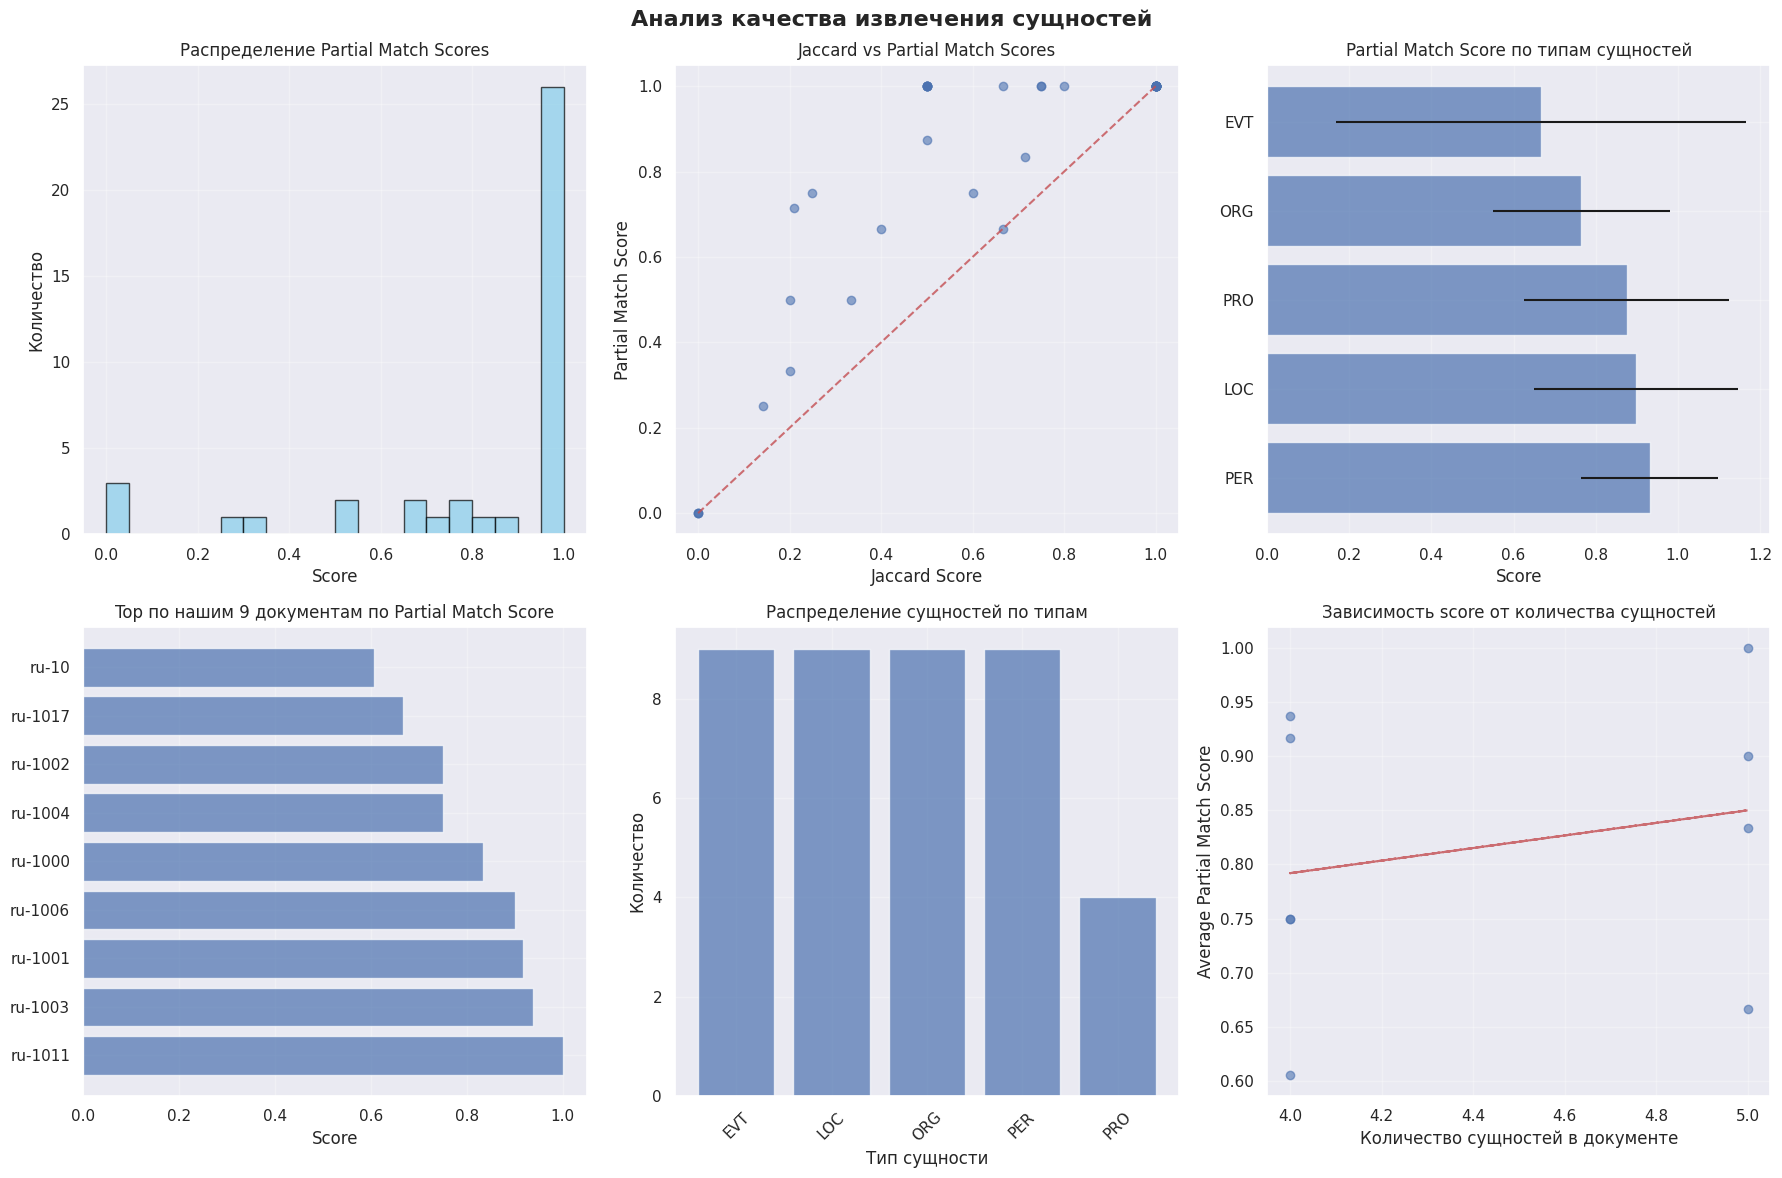

/tmp/ipython-input-1686261733.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


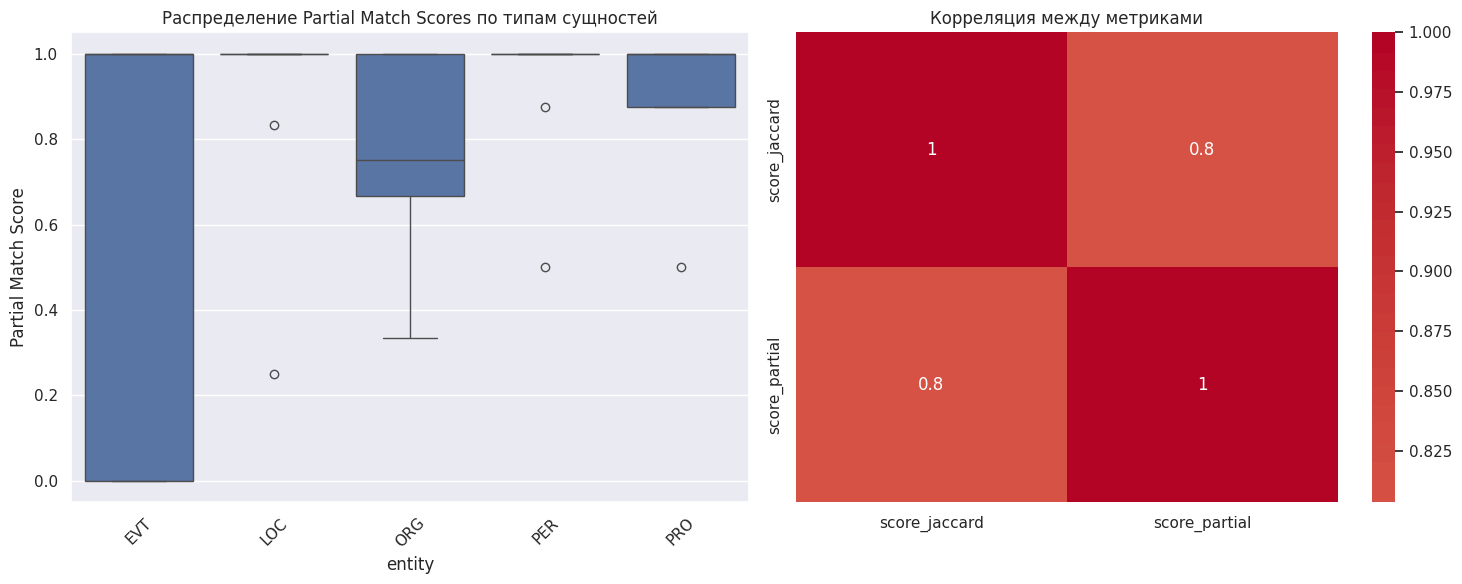


Какие выводы делаем?
--------------------------------------------------
1. Высокое общее качество извлечения сущностей
2. Средний Partial Match Score: 0.821
3. Лучше всего извлекаются сущности типа 'PER': 0.931
4. Хуже всего извлекаются сущности типа 'EVT': 0.667
5. Лучший документ: 'ru-1011' (score: 1.000)
6. Худший документ: 'ru-10' (score: 0.606)
7. Большой разброс (что-то не так сделано) в качестве между разными случаями
8. Partial Match метрика значительно выше Jaccard метрики - модель хорошо справляется с частичными совпадениями

Доп полезные наблюдения:
   Самые частые типы сущностей: EVT (9), LOC (9), ORG (9)
   Полных совпадений (score=1.0): 65.0%
   Полных провалов (score=0.0): 7.5%


In [43]:
print("-" * 50)
# Проверяем на тчо что я нигде ничего не потерял
required_columns = ['score_jaccard', 'score_partial', 'entity', 'document_id']
missing_columns = [col for col in required_columns if col not in dffffff_with_scores.columns]

if missing_columns:
  print(f"Отсутствуют эти колонки: {missing_columns}")

# Делаем анализ по сущностям
entity_results = analyze_metrics_by_entity(dffffff_with_scores)
# Делаем анализ по документам
doc_results = analyze_metrics_by_document(dffffff_with_scores)
# Смотрим подробную статту
stats = calculate_detailed_statistics(dffffff_with_scores)
# Креатив виззуализации
create_visualizations(dffffff_with_scores, entity_results, doc_results)
# Формулируем выводы
make_conclusions(dffffff_with_scores, entity_results, doc_results, stats)

In [45]:
entity_results.to_csv('entity_results.csv', encoding='utf-8')
doc_results.to_csv('document_results.csv', encoding='utf-8')

**Какие выводы делаем по 6 заданию?**
--------------------------------------------------
1. Высокое общее качество извлечения сущностей (несмотря даже на то, что, например, Brexit и брекзит по своей сути одно и то же в нашем понимании, но машинка сравнивает тупо символы лексикографически, и они никак не похожи для нее на разных языках)
2. Средний Partial Match Score: 0.821 (видно что она значительно метрики Jaccard). При этом по графику 1 видно, что распределение Partial Matches распределено по значению точности score в большей мере к значению 1.0
3. Лучше всего извлекаются сущности типа 'PER': 0.931 (отмечено на 3 графике)
4. Хуже всего извлекаются сущности типа 'EVT': 0.667 (показано на 3 графике)
5. В целом, по Partial Match Score очень неплохое общее извлечение сущностей. Можно посмотреть на топ наших документов и увидеть, что 5/9 документов обладают значением score >= 0.8 (график 4)
6. Лучший документ: 'ru-1011' (score: 1.000) (тот же график 4)
7. Худший документ: 'ru-10' (score: 0.606) (на графике 4 это отбражено)
8. Большой разброс (что-то не так сделано) в качестве между разными случаями. Предполагаю, что это из-за моих ошибок в реализации того,что для нас многие слова на разных языках в понимании это одно и то же, но для модели нет умения различать такие случаи без спец реализаций (она смотрит на точное совпадение лексикографическое на одном и том же языке или на содержание подстрок в строках, после проверки помечая частичное или полное совпадение)
9. Partial Match метрика значительно выше Jaccard метрики - модель хорошо справляется с частичными совпадениями, что является несомненным преимуществом
10. Можно добиться лучшего качества модели более хорошей и точной реализацией, если сосредоточиться на определенных аспектах, дообучив.
11. Во время моих запросов в GigaChat и после просьбы сформировать ответы в одно сообщение GigaChat часто менял ответы по порядку местами или писал не то, что выдавал при запросах выше. Поэтому требовалось перепроверять валидность ответа GigaChat.

**Доп полезные наблюдения:**
- Самые частые типы сущностей: EVT (9), LOC (9), ORG (9)
- Полных совпадений (score=1.0): 65.0%, что является достаточно хорошим показателем для моей реализации
- Полных провалов (score=0.0): 7.5% - из-за недостатков моей реализации и возможных ошибок ответов GigaChat

### Задание 7
Есть ли зависимость метрик от длины документа? Постройте графики, чтобы ответить на вопрос.


In [52]:
def analyze_length_impact(df):
    print("Анализ зависимости метрик от длины документа")
    print("-" * 50)

    # Создаем копию датафрейма для анализа, поскольку не хочу под конец все испортить
    analysis_df = df.copy()
    # Вычислим длину каждого документа в символах и словах
    analysis_df['doc_length_chars'] = analysis_df['document_text'].str.len()
    analysis_df['doc_length_words'] = analysis_df['document_text'].str.split().str.len()
    # Агрегируем по документам
    doc_analysis = analysis_df.groupby('document_id').agg({
        'score_jaccard': 'mean',
        'score_partial': 'mean',
        'doc_length_chars': 'first',
        'doc_length_words': 'first',
        'entity': 'count'  # количество сущностей в документе
    }).reset_index()

    doc_analysis.columns = ['document_id', 'avg_jaccard', 'avg_partial',
                           'length_chars', 'length_words', 'entity_count']

    print("Статистика по длине документов:")
    print(f"Средняя длина документа: {doc_analysis['length_chars'].mean():.0f} символов")
    print(f"Среднее количество слов: {doc_analysis['length_words'].mean():.0f} слов")
    print(f"Минимальная длина: {doc_analysis['length_chars'].min():.0f} символов")
    print(f"Максимальная длина: {doc_analysis['length_chars'].max():.0f} символов")
    print(f"Полезно посмотреть на стандартное отклонение: {doc_analysis['length_chars'].std():.0f} символов")

    return doc_analysis, analysis_df

In [53]:
from scipy import stats

In [54]:
def calculate_correlations(doc_analysis):
    print("\nВычисление корреляций между длиной документа и метриками")
    print("-" * 50)
    # Корреляции с длиной в символах
    corr_chars_jaccard = stats.pearsonr(doc_analysis['length_chars'], doc_analysis['avg_jaccard'])
    corr_chars_partial = stats.pearsonr(doc_analysis['length_chars'], doc_analysis['avg_partial'])
    # Корреляции с количеством слов
    corr_words_jaccard = stats.pearsonr(doc_analysis['length_words'], doc_analysis['avg_jaccard'])
    corr_words_partial = stats.pearsonr(doc_analysis['length_words'], doc_analysis['avg_partial'])
    # Корреляции с количеством сущностей
    corr_entities_jaccard = stats.pearsonr(doc_analysis['entity_count'], doc_analysis['avg_jaccard'])
    corr_entities_partial = stats.pearsonr(doc_analysis['entity_count'], doc_analysis['avg_partial'])
    # Посмотрим теперь чтоб позже получше сформулировать выводы
    print("Корреляция Пирсона (коэффициент, p-value):")
    print(f"Длина (символы) vs Jaccard: {corr_chars_jaccard[0]:.3f} (p={corr_chars_jaccard[1]:.3f})")
    print(f"Длина (символы) vs Partial: {corr_chars_partial[0]:.3f} (p={corr_chars_partial[1]:.3f})")
    print(f"Длина (слова) vs Jaccard:    {corr_words_jaccard[0]:.3f} (p={corr_words_jaccard[1]:.3f})")
    print(f"Длина (слова) vs Partial:    {corr_words_partial[0]:.3f} (p={corr_words_partial[1]:.3f})")
    print(f"Кол-во сущностей vs Jaccard: {corr_entities_jaccard[0]:.3f} (p={corr_entities_jaccard[1]:.3f})")
    print(f"Кол-во сущностей vs Partial: {corr_entities_partial[0]:.3f} (p={corr_entities_partial[1]:.3f})")

    return {
        'chars_jaccard': corr_chars_jaccard,
        'chars_partial': corr_chars_partial,
        'words_jaccard': corr_words_jaccard,
        'words_partial': corr_words_partial,
        'entities_jaccard': corr_entities_jaccard,
        'entities_partial': corr_entities_partial
    }

In [55]:
def create_length_visualizations(doc_analysis, correlations):
    """
    Создаем графики для анализа зависимости от длины
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Зависимость метрик качества от характеристик документов',
                 fontsize=16, fontweight='bold')

    # Тут сталкиваем длина в символах vs Partial Match Score
    axes[0, 0].scatter(doc_analysis['length_chars'], doc_analysis['avg_partial'],
                      alpha=0.7, s=60)
    axes[0, 0].set_title('Зависимость от длины документа (символы)')
    axes[0, 0].set_xlabel('Длина документа (символы)')
    axes[0, 0].set_ylabel('Partial Match Score')
    axes[0, 0].grid(True, alpha=0.3)

    # Посмотреть на лин регрессию тоже полезно
    z = np.polyfit(doc_analysis['length_chars'], doc_analysis['avg_partial'], 1)
    p = np.poly1d(z)
    axes[0, 0].plot(doc_analysis['length_chars'], p(doc_analysis['length_chars']),
                   "r--", alpha=0.8, label=f'тренд (r={correlations["chars_partial"][0]:.3f})')
    axes[0, 0].legend()

    # Тут сталкиваем количество слов vs Partial Match Score
    axes[0, 1].scatter(doc_analysis['length_words'], doc_analysis['avg_partial'],
                      alpha=0.7, s=60)
    axes[0, 1].set_title('Зависимость от количества слов')
    axes[0, 1].set_xlabel('Количество слов в документе')
    axes[0, 1].set_ylabel('Partial Match Score')
    axes[0, 1].grid(True, alpha=0.3)

    # Посмотреть на лин регрессию тоже полезно
    z = np.polyfit(doc_analysis['length_words'], doc_analysis['avg_partial'], 1)
    p = np.poly1d(z)
    axes[0, 1].plot(doc_analysis['length_words'], p(doc_analysis['length_words']),
                   "r--", alpha=0.8, label=f'тренд (r={correlations["words_partial"][0]:.3f})')
    axes[0, 1].legend()

    # Тут. сталкиваем количество сущностей vs Partial Match Score
    axes[0, 2].scatter(doc_analysis['entity_count'], doc_analysis['avg_partial'],
                      alpha=0.7, s=60)
    axes[0, 2].set_title('Зависимость от количества сущностей')
    axes[0, 2].set_xlabel('Количество сущностей в документе')
    axes[0, 2].set_ylabel('Partial Match Score')
    axes[0, 2].grid(True, alpha=0.3)

    # Посмотреть на лин регрессию тоже полезно
    z = np.polyfit(doc_analysis['entity_count'], doc_analysis['avg_partial'], 1)
    p = np.poly1d(z)
    axes[0, 2].plot(doc_analysis['entity_count'], p(doc_analysis['entity_count']),
                   "r--", alpha=0.8, label=f'тренд (r={correlations["entities_partial"][0]:.3f})')
    axes[0, 2].legend()

    # Смотрим распределение длин документов
    axes[1, 0].hist(doc_analysis['length_chars'], bins=15, alpha=0.7,
                   color='lightblue', edgecolor='black')
    axes[1, 0].set_title('Распределение длин документов')
    axes[1, 0].set_xlabel('Длина документа (символы)')
    axes[1, 0].set_ylabel('Количество документов')
    axes[1, 0].grid(True, alpha=0.3)

    # Делаем сравнение коротких и длинных документов
    median_length = doc_analysis['length_chars'].median()
    short_docs = doc_analysis[doc_analysis['length_chars'] <= median_length]
    long_docs = doc_analysis[doc_analysis['length_chars'] > median_length]

    categories = ['Короткие документы', 'Длинные документы']
    jaccard_means = [short_docs['avg_jaccard'].mean(), long_docs['avg_jaccard'].mean()]
    partial_means = [short_docs['avg_partial'].mean(), long_docs['avg_partial'].mean()]

    x = np.arange(len(categories))
    width = 0.35

    axes[1, 1].bar(x - width/2, jaccard_means, width, label='Jaccard', alpha=0.7)
    axes[1, 1].bar(x + width/2, partial_means, width, label='Partial', alpha=0.7)
    axes[1, 1].set_title('Сравнение коротких и длинных документов')
    axes[1, 1].set_xlabel('Категория документов')
    axes[1, 1].set_ylabel('Средний Score')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(categories)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Посмотрим на Heatmap корреляций
    corr_matrix = doc_analysis[['length_chars', 'length_words', 'entity_count',
                              'avg_jaccard', 'avg_partial']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                ax=axes[1, 2], fmt='.3f')
    axes[1, 2].set_title('Матрица корреляций')

    plt.tight_layout()
    plt.show()

    # Построим доп графики тоже
    create_additional_length_plots(doc_analysis)

def create_additional_length_plots(doc_analysis):
    """
    Дополнительные графики для лучшего анализа и выводов
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Сделаем boxplot по квартилям длины
    doc_analysis['length_quartile'] = pd.qcut(doc_analysis['length_chars'],
                                             q=4, labels=['Q1 (короткие)', 'Q2', 'Q3', 'Q4 (длинные)'])

    sns.boxplot(data=doc_analysis, x='length_quartile', y='avg_partial', ax=axes[0])
    axes[0].set_title('Распределение Partial Match Score по квартилям длины')
    axes[0].set_xlabel('Квартиль длины документа')
    axes[0].set_ylabel('Partial Match Score')
    axes[0].tick_params(axis='x', rotation=45)

    # Посмотрим также на плотность распределения scores для разных длин
    median_length = doc_analysis['length_chars'].median()
    short_scores = doc_analysis[doc_analysis['length_chars'] <= median_length]['avg_partial']
    long_scores = doc_analysis[doc_analysis['length_chars'] > median_length]['avg_partial']

    axes[1].hist(short_scores, bins=15, alpha=0.6, label='Короткие документы', density=True)
    axes[1].hist(long_scores, bins=15, alpha=0.6, label='Длинные документы', density=True)
    axes[1].set_title('Плотность распределения Scores по длине')
    axes[1].set_xlabel('Partial Match Score')
    axes[1].set_ylabel('Плотность')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [59]:
def perform_statistical_tests(doc_analysis):
    print("\nСтатистические тесты для проверки значимости различий")
    print("-" * 50)

    # Разделим дла проверки на короткие и длинные документы
    median_length = doc_analysis['length_chars'].median()
    short_docs = doc_analysis[doc_analysis['length_chars'] <= median_length]
    long_docs = doc_analysis[doc_analysis['length_chars'] > median_length]

    # Проведем T-тест для сравнения средних
    ttest_partial = stats.ttest_ind(short_docs['avg_partial'], long_docs['avg_partial'])
    ttest_jaccard = stats.ttest_ind(short_docs['avg_jaccard'], long_docs['avg_jaccard'])

    print("T-тест для коротких vs длинных документов:")
    print(f"Partial Match: t={ttest_partial.statistic:.3f}, p={ttest_partial.pvalue:.3f}")
    print(f"Jaccard Score: t={ttest_jaccard.statistic:.3f}, p={ttest_jaccard.pvalue:.3f}")

    # Проверка на нормальность (наверн будет все плохо но лучше чекать для лучшего вывода)
    _, p_norm_short = stats.normaltest(short_docs['avg_partial'])
    _, p_norm_long = stats.normaltest(long_docs['avg_partial'])

    print(f"\nТест на нормальность (p-value):")
    print(f"Короткие документы: {p_norm_short:.3f}")
    print(f"Длинные документы: {p_norm_long:.3f}")

    return {
        'ttest_partial': ttest_partial,
        'ttest_jaccard': ttest_jaccard,
        'normality_short': p_norm_short,
        'normality_long': p_norm_long
    }

def draw_conclusions(correlations, statistical_tests, doc_analysis):
    print("\nФормулировка выводов на основе анализа в зависимости от длины документов")
    print("-" * 50)

    conclusions = []
    # Проведем анализ корреляций
    corr_partial = correlations['chars_partial'][0]
    p_value = correlations['chars_partial'][1]

    if abs(corr_partial) > 0.5:
        strength = "сильная"
    elif abs(corr_partial) > 0.3:
        strength = "умеренная"
    elif abs(corr_partial) > 0.1:
        strength = "слабая"
    else:
        strength = "очень слабая"

    if corr_partial > 0:
        direction = "положительная"
    else:
        direction = "отрицательная"

    conclusions.append(f"{strength.capitalize()} {direction} корреляция между длиной документа и качеством (r={corr_partial:.3f})")

    # Статистическая значимость какая
    if p_value < 0.05:
        conclusions.append("Зависимость статистически значима (p < 0.05)")
    else:
        conclusions.append("Зависимость не является статистически значимой")

    # Делаем сравнение коротких и длинных документов
    median_length = doc_analysis['length_chars'].median()
    short_avg = doc_analysis[doc_analysis['length_chars'] <= median_length]['avg_partial'].mean()
    long_avg = doc_analysis[doc_analysis['length_chars'] > median_length]['avg_partial'].mean()

    if long_avg > short_avg + 0.1:
        conclusions.append("Длинные документы показывают значительно лучшее качество")
    elif short_avg > long_avg + 0.1:
        conclusions.append("Короткие документы показывают значительно лучшее качество")
    else:
        conclusions.append("Качество сопоставимо для документов разной длины")

    conclusions.append(f"Средний score для коротких документов: {short_avg:.3f}")
    conclusions.append(f"Средний score для длинных документов: {long_avg:.3f}")

    # Смотрим на общий вывод исходя из наших корреляуий
    if corr_partial > 0.3 and p_value < 0.05:
        conclusions.append("Общий вывод: Модель лучше работает с длинными документами")
    elif corr_partial < -0.3 and p_value < 0.05:
        conclusions.append("Общий вывод: Модель лучше работает с короткими документами")
    else:
        conclusions.append("Общий вывод: Длина документа не оказывает существенного влияния на качество")

    # Выводим выводы
    for i, conclusion in enumerate(conclusions, 1):
        print(f"{i}. {conclusion}")



Анализ зависимости метрик от длины документа
--------------------------------------------------
Статистика по длине документов:
Средняя длина документа: 1271 символов
Среднее количество слов: 172 слов
Минимальная длина: 315 символов
Максимальная длина: 5085 символов
Полезно посмотреть на стандартное отклонение: 1475 символов

Вычисление корреляций между длиной документа и метриками
--------------------------------------------------
Корреляция Пирсона (коэффициент, p-value):
Длина (символы) vs Jaccard: -0.593 (p=0.092)
Длина (символы) vs Partial: -0.531 (p=0.141)
Длина (слова) vs Jaccard:    -0.588 (p=0.096)
Длина (слова) vs Partial:    -0.529 (p=0.143)
Кол-во сущностей vs Jaccard: 0.029 (p=0.941)
Кол-во сущностей vs Partial: 0.230 (p=0.551)


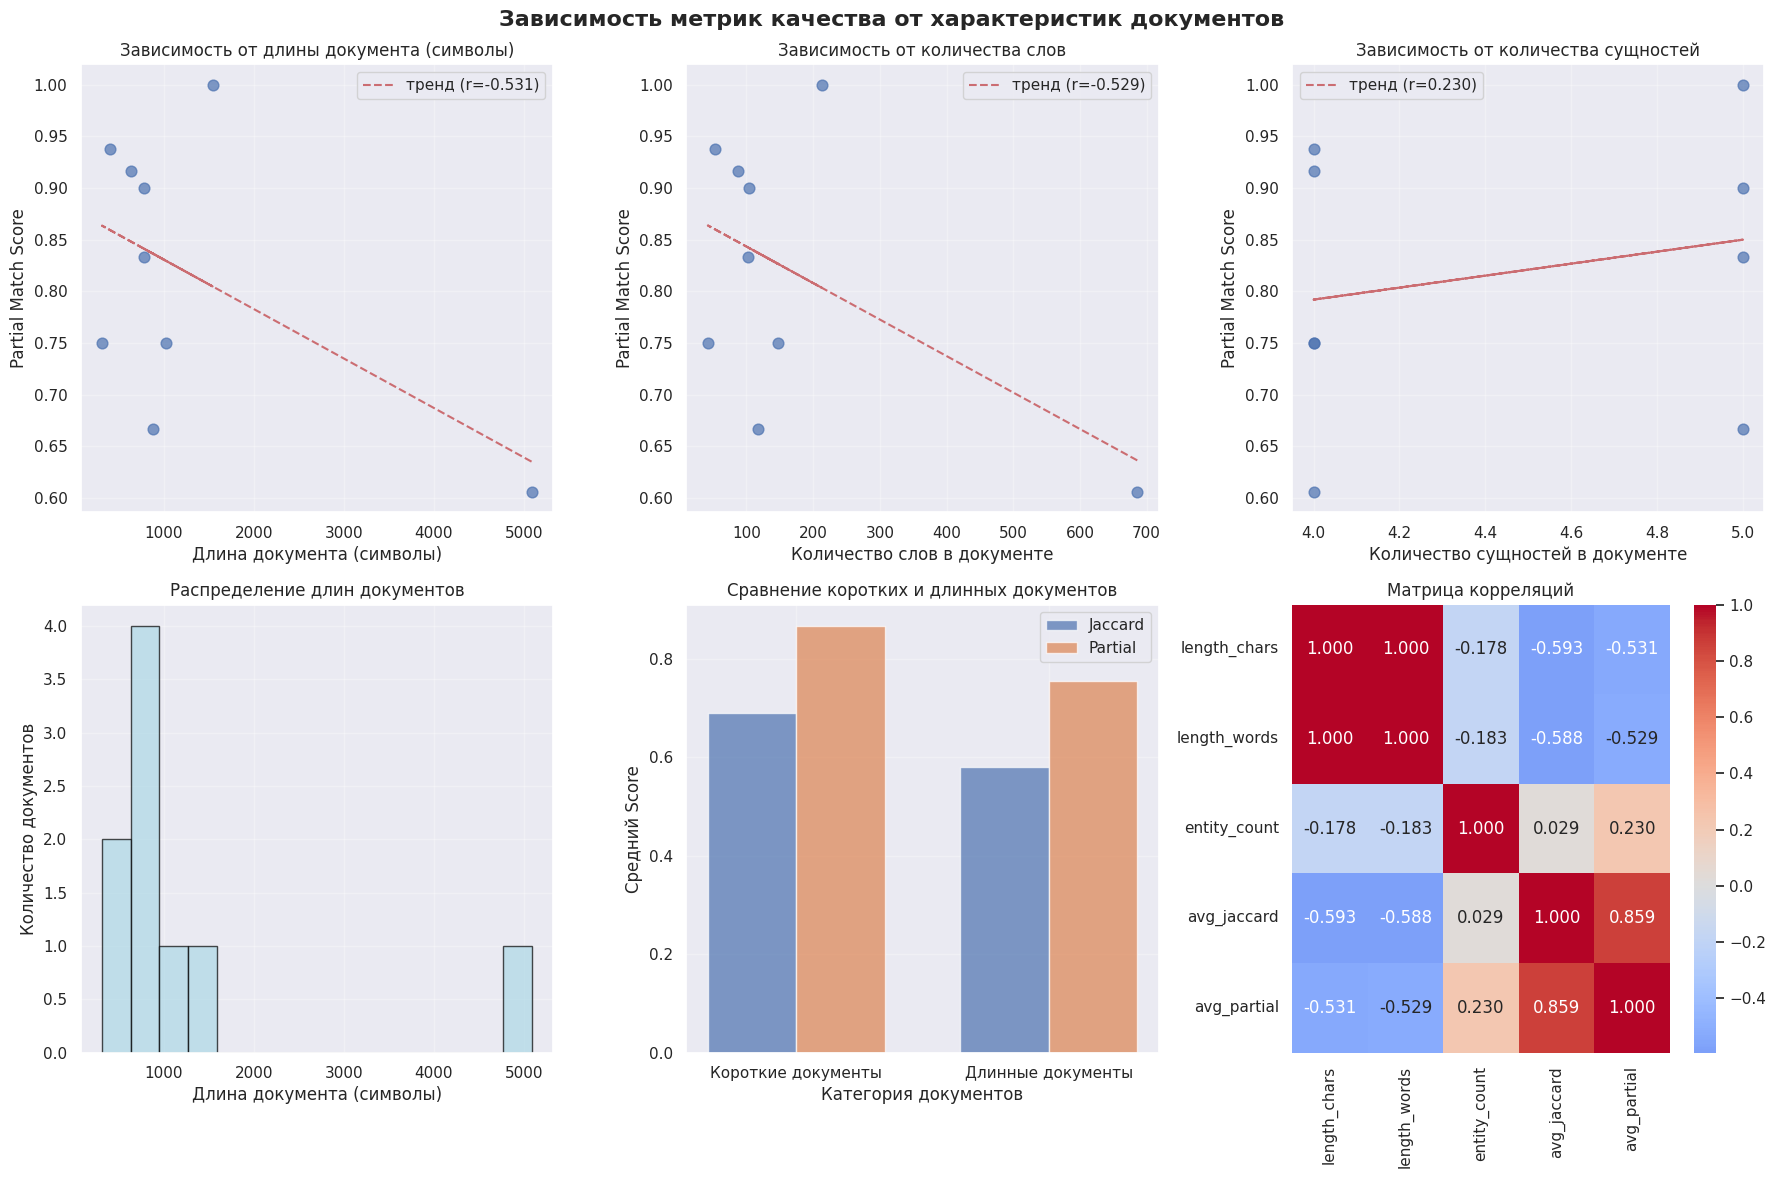

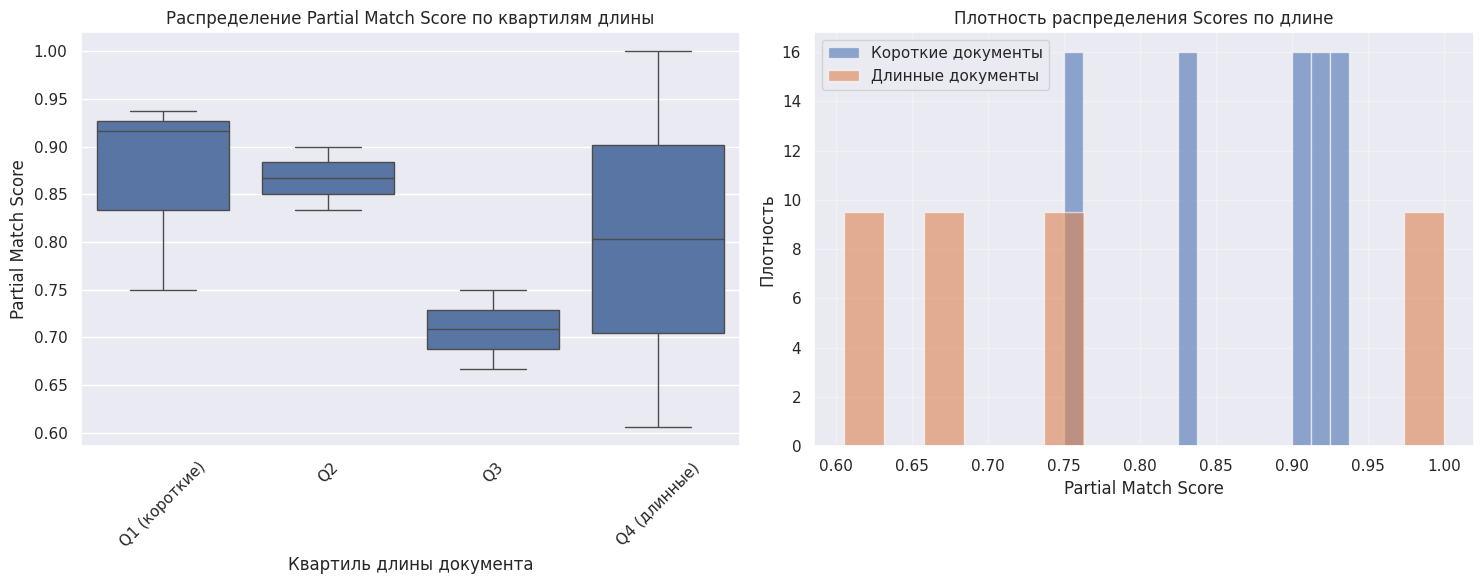


Статистические тесты для проверки значимости различий
--------------------------------------------------
T-тест для коротких vs длинных документов:
Partial Match: t=1.310, p=0.231
Jaccard Score: t=1.003, p=0.349

Тест на нормальность (p-value):
Короткие документы: nan
Длинные документы: nan

Формулировка выводов на основе анализа в зависимости от длины документов
--------------------------------------------------
1. Сильная отрицательная корреляция между длиной документа и качеством (r=-0.531)
2. Зависимость не является статистически значимой
3. Короткие документы показывают значительно лучшее качество
4. Средний score для коротких документов: 0.868
5. Средний score для длинных документов: 0.756
6. Общий вывод: Длина документа не оказывает существенного влияния на качество


/tmp/ipython-input-2836486060.py:19: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p_norm_short = stats.normaltest(short_docs['avg_partial'])
/tmp/ipython-input-2836486060.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p_norm_long = stats.normaltest(long_docs['avg_partial'])


In [61]:
if 'document_text' not in dffffff_with_scores.columns:
  print("Отсутствует колонка 'document_text'")

# Смотрим как влияет длина
doc_analysis, extended_df = analyze_length_impact(dffffff_with_scores)
# Вычисляем корреляции
correlations = calculate_correlations(doc_analysis)
# Строим графики
create_length_visualizations(doc_analysis, correlations)
# Сделаем статистические тесты для вывода
statistical_tests = perform_statistical_tests(doc_analysis)
# Сделаем выводы
draw_conclusions(correlations, statistical_tests, doc_analysis)
# doc_analysis.to_csv('document_length_analysis.csv', index=False, encoding='utf-8')

In [62]:
doc_analysis.to_csv('document_length_analysis.csv', index=False, encoding='utf-8')

Формулировка выводов на основе анализа в зависимости от длины документов для задания 7
--------------------------------------------------
1. Сильная отрицательная корреляция между длиной документа и качеством решения NER (r=-0.531). То есть наблюдается обратная зависимость метрик от длины документа. (Когда одно увеличивается, другое соответственно уменьшается. И наоборот)
2. При этом сама по себе зависимость не является статистически значимой.
3. Короткие документы показывают значительно лучшее качество. (это видно и из графиков)
4. Средний score для коротких документов: 0.868
5. Средний score для длинных документов: 0.756
6. Jaccard и Partial Score в среднем выше у коротких документов чем у длинных (график 5)
7. Видно из графика 4, что не соблюдается баланс классов по длине документов (коротких документов значительно больше чем длинных)

**Общий вывод: Длина документа не оказывает существенного влияния на качество, но при этом наблюдается обратная зависимость.**

### Задание 8
Проведите анализ ошибок. Когда модель чаще отвечает правильно, а когда ошибается? Предложите варианты, как повысить метрики.


In [65]:
def analyze_errors(df):
    print("Комплексный анализ ошибок модели")
    print("-" * 50)

    # Создаем копию для анализа
    analysis_df = df.copy()
    # Добавляем категории ошибок
    analysis_df['error_category'] = analysis_df.apply(categorize_error, axis=1)
    analysis_df['is_correct'] = analysis_df['score_partial'] == 1.0
    analysis_df['is_partial'] = (analysis_df['score_partial'] > 0) & (analysis_df['score_partial'] < 1.0)
    analysis_df['is_wrong'] = analysis_df['score_partial'] == 0.0

    return analysis_df

In [66]:
def categorize_error(row):
    # Категоризация типов ошибок
    gold = row['gold_answer']
    pred = row['gigachat_entities']
    score = row['score_partial']

    if score == 1.0:
        return "correct"
    elif score == 0.0:
        return "complete_miss"
    elif score < 0.3:
        return "major_error"
    elif score < 0.7:
        return "partial_match"
    else:
        return "good_match"

In [67]:
def analyze_error_patterns(df):
    print("\nАнализ ошибок по категориям")
    print("-" * 50)

    error_stats = df['error_category'].value_counts()
    for category, count in error_stats.items():
        percentage = count / len(df) * 100
        print(f"{category:15}: {count:3d} ({percentage:5.1f}%)")

    # Рассмотрим наши entity type
    print("\nАнализ ошибок по типам сущностей")
    entity_error_rates = df.groupby('entity').agg({
        'score_partial': 'mean',
        'is_correct': 'mean',
        'is_wrong': 'mean'
    }).round(3)

    entity_error_rates = entity_error_rates.sort_values('score_partial')
    print(entity_error_rates)

    return error_stats, entity_error_rates

In [68]:
def analyze_specific_errors(df):
    print("\nАнализ конкретных примеров ошибок")
    print("-" * 50)

    # Смотрим где полные промахи
    complete_misses = df[df['error_category'] == 'complete_miss']
    print(f"Полные промахи (score=0.0): {len(complete_misses)} примеров")

    if not complete_misses.empty:
        print("\nПримеры полных промахов:")
        for idx, row in complete_misses.head(5).iterrows():
            print(f"{row['entity']}: Gold='{row['gold_answer']}' -> Pred={row['gigachat_entities']}")

    # Смотрим на частичные совпадения
    partial_matches = df[df['error_category'] == 'partial_match']
    print(f"\nЧастичные совпадения (0.3 < score < 0.7): {len(partial_matches)} примеров")

    if not partial_matches.empty:
        print("\nПримеры частичных совпадений:")
        for idx, row in partial_matches.head(5).iterrows():
            print(f"{row['entity']}: Gold='{row['gold_answer']}' -> Pred={row['gigachat_entities']}")

    return complete_misses, partial_matches

In [69]:
def analyze_success_cases(df):
    print("\nАнализ случаев когда моя модель работает хорошо")
    print("-" * 50)

    success_cases = df[df['error_category'] == 'correct']
    good_cases = df[df['error_category'] == 'good_match']

    print(f"Идеальные совпадения (score=1.0): {len(success_cases)}")
    print(f"Хорошие совпадения (score>0.7): {len(good_cases)}")

    # Анализ успешных типов сущностей
    success_by_entity = success_cases['entity'].value_counts()
    print(f"\nЛучшие типы сущностей по точности:")
    for entity, count in success_by_entity.head(5).items():
        total = len(df[df['entity'] == entity])
        accuracy = count / total * 100
        print(f"  {entity}: {count}/{total} ({accuracy:.1f}%)")

    return success_cases, good_cases

In [70]:
def analyze_text_patterns(df):
    print("\nПроведем анализ текстовых паттернов в ошибках")
    print("-" * 50)

    # Смотрим длину текста и ошибки
    df['text_length'] = df['document_text'].str.len()

    # Проводим анализ контекста вокруг сущностей
    error_cases = df[df['score_partial'] < 0.7]
    success_cases = df[df['score_partial'] >= 0.7]

    print("Сравнение характеристик текстов:")
    print(f"Средняя длина текста с ошибками: {error_cases['text_length'].mean():.0f} симв.")
    print(f"Средняя длина успешных текстов: {success_cases['text_length'].mean():.0f} симв.")

    # Сделаем также анализ частых слов в ошибках
    analyze_frequent_terms(df)

    return error_cases, success_cases

In [71]:
def analyze_frequent_terms(df):
    # Сделаем также анализ частых терминов в ошибках и успехах
    # Сначала собираем тексты с ошибками и успехами
    error_texts = ' '.join(df[df['score_partial'] < 0.5]['document_text'].astype(str))
    success_texts = ' '.join(df[df['score_partial'] > 0.8]['document_text'].astype(str))

    # Тут решил провести анализ частотности слов
    # Можно, наверняка, улучшить с помощью nltk, но это будет очень долго
    # Пользуюсь тем, что есть
    error_words = re.findall(r'\b[а-яёa-z]{4,}\b', error_texts.lower())
    success_words = re.findall(r'\b[а-яёa-z]{4,}\b', success_texts.lower())

    error_freq = Counter(error_words).most_common(10)
    success_freq = Counter(success_words).most_common(10)

    print("\nЧастые слова в текстах с ошибками:")
    for word, count in error_freq:
        print(f"  {word}: {count}")

    print("\nЧастые слова в успешных текстах:")
    for word, count in success_freq:
        print(f"  {word}: {count}")


In [72]:
def create_error_visualizations(df, error_stats, entity_error_rates):
    # Визуализируем наш анализ ошибок
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Анализ ошибок извлечения сущностей', fontsize=16, fontweight='bold')

    # Поглядим на распределение ошибок по категориям
    categories = error_stats.index
    counts = error_stats.values

    axes[0, 0].bar(categories, counts, color=['green', 'lightgreen', 'orange', 'red'])
    axes[0, 0].set_title('Распределение ошибок по категориям')
    axes[0, 0].set_ylabel('Количество')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Посмотрим на точность по типам сущностей
    entities = entity_error_rates.index
    accuracy = entity_error_rates['is_correct'] * 100
    axes[0, 1].barh(range(len(entities)), accuracy)
    axes[0, 1].set_yticks(range(len(entities)))
    axes[0, 1].set_yticklabels(entities)
    axes[0, 1].set_title('Точность по типам сущностей (%)')
    axes[0, 1].set_xlabel('Точность (%)')

    # Посмотрим на распределение scores по типам сущностей
    entity_scores = []
    for entity in entities:
        entity_scores.append(df[df['entity'] == entity]['score_partial'].values)

    axes[0, 2].boxplot(entity_scores, labels=entities)
    axes[0, 2].set_title('Распределение Scores по типам сущностей')
    axes[0, 2].set_ylabel('Partial Match Score')
    axes[0, 2].tick_params(axis='x', rotation=45)
    # Посмотрим еще раз на зависимость от длины текста
    axes[1, 0].scatter(df['text_length'], df['score_partial'], alpha=0.6)
    axes[1, 0].set_title('Зависимость качества от длины текста')
    axes[1, 0].set_xlabel('Длина текста (символы)')
    axes[1, 0].set_ylabel('Partial Match Score')
    axes[1, 0].grid(True, alpha=0.3)
    # Визуалмзация heatmap ошибок по типам сущностей и документам
    error_heatmap_data = df.pivot_table(
        index='document_id',
        columns='entity',
        values='score_partial',
        aggfunc='mean'
    ).fillna(-1)

    if not error_heatmap_data.empty:
        im = axes[1, 1].imshow(error_heatmap_data, aspect='auto', cmap='RdYlGn')
        axes[1, 1].set_title('Heatmap качества по документам и сущностям')
        axes[1, 1].set_xlabel('Тип сущности')
        axes[1, 1].set_ylabel('Document ID')
        plt.colorbar(im, ax=axes[1, 1])

    # На всякий случай поглядим на кумулятивное распределение scores
    sorted_scores = np.sort(df['score_partial'])
    y_vals = np.arange(len(sorted_scores)) / float(len(sorted_scores))
    axes[1, 2].plot(sorted_scores, y_vals)
    axes[1, 2].set_title('Кумулятивное распределение Scores')
    axes[1, 2].set_xlabel('Partial Match Score')
    axes[1, 2].set_ylabel('Доля примеров')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Порог 0.5')
    axes[1, 2].legend()

    plt.tight_layout()
    plt.show()

In [73]:
def provide_improvement_recommendations(df, error_stats, entity_error_rates):
    print("\nПредложение рекомендаций по улучшению метрик")
    print("-" * 50)

    recommendations = []

    # Про худшие типы сущностей в анализе
    worst_entities = entity_error_rates.head(3)
    for entity, row in worst_entities.iterrows():
        accuracy = row['is_correct'] * 100
        recommendations.append(f"Сущности типа '{entity}' имеют низкую точность ({accuracy:.1f}%)")
        recommendations.append(f"- Попробовать улучшить промпты для извлечения {entity}")
        recommendations.append(f"- Добавить примеры для {entity} в few-shot learning")

    # Про полные промахов
    complete_misses = len(df[df['is_wrong']])
    if complete_misses > len(df) * 0.2:  # Если больше 20% полных промахов
        recommendations.append(f"Высокий процент полных промахов ({complete_misses/len(df)*100:.1f}%)")
        recommendations.append("- Попробовать величить контекст в промптах")
        recommendations.append("- Попробовать добавить обработку синонимов и вариантов написания")

    # Про анализ текстовых паттернов
    avg_text_length = df['text_length'].mean()
    if avg_text_length > 2000:
        recommendations.append("Документы слишком длинные")
        recommendations.append("- Попробовать разбивать длинные документы на части")
        recommendations.append("- Использовать скользящее окно для обработки")


    # Выводим рекомендации
    for rec in recommendations:
        print(rec)

Комплексный анализ ошибок модели
--------------------------------------------------

Анализ ошибок по категориям
--------------------------------------------------
correct        :  26 ( 65.0%)
partial_match  :   5 ( 12.5%)
good_match     :   5 ( 12.5%)
complete_miss  :   3 (  7.5%)
major_error    :   1 (  2.5%)

Анализ ошибок по типам сущностей
        score_partial  is_correct  is_wrong
entity                                     
EVT             0.667       0.667     0.333
ORG             0.765       0.333     0.000
PRO             0.875       0.750     0.000
LOC             0.898       0.778     0.000
PER             0.931       0.778     0.000

Анализ конкретных примеров ошибок
--------------------------------------------------
Полные промахи (score=0.0): 3 примеров

Примеры полных промахов:
EVT: Gold='['Brexit']' -> Pred=['брекзит']
EVT: Gold='['Brexit']' -> Pred=['Брекзит']
EVT: Gold='['Brexit']' -> Pred=[]

Частичные совпадения (0.3 < score < 0.7): 5 примеров

Примеры частичных 

/tmp/ipython-input-3546208535.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 2].boxplot(entity_scores, labels=entities)


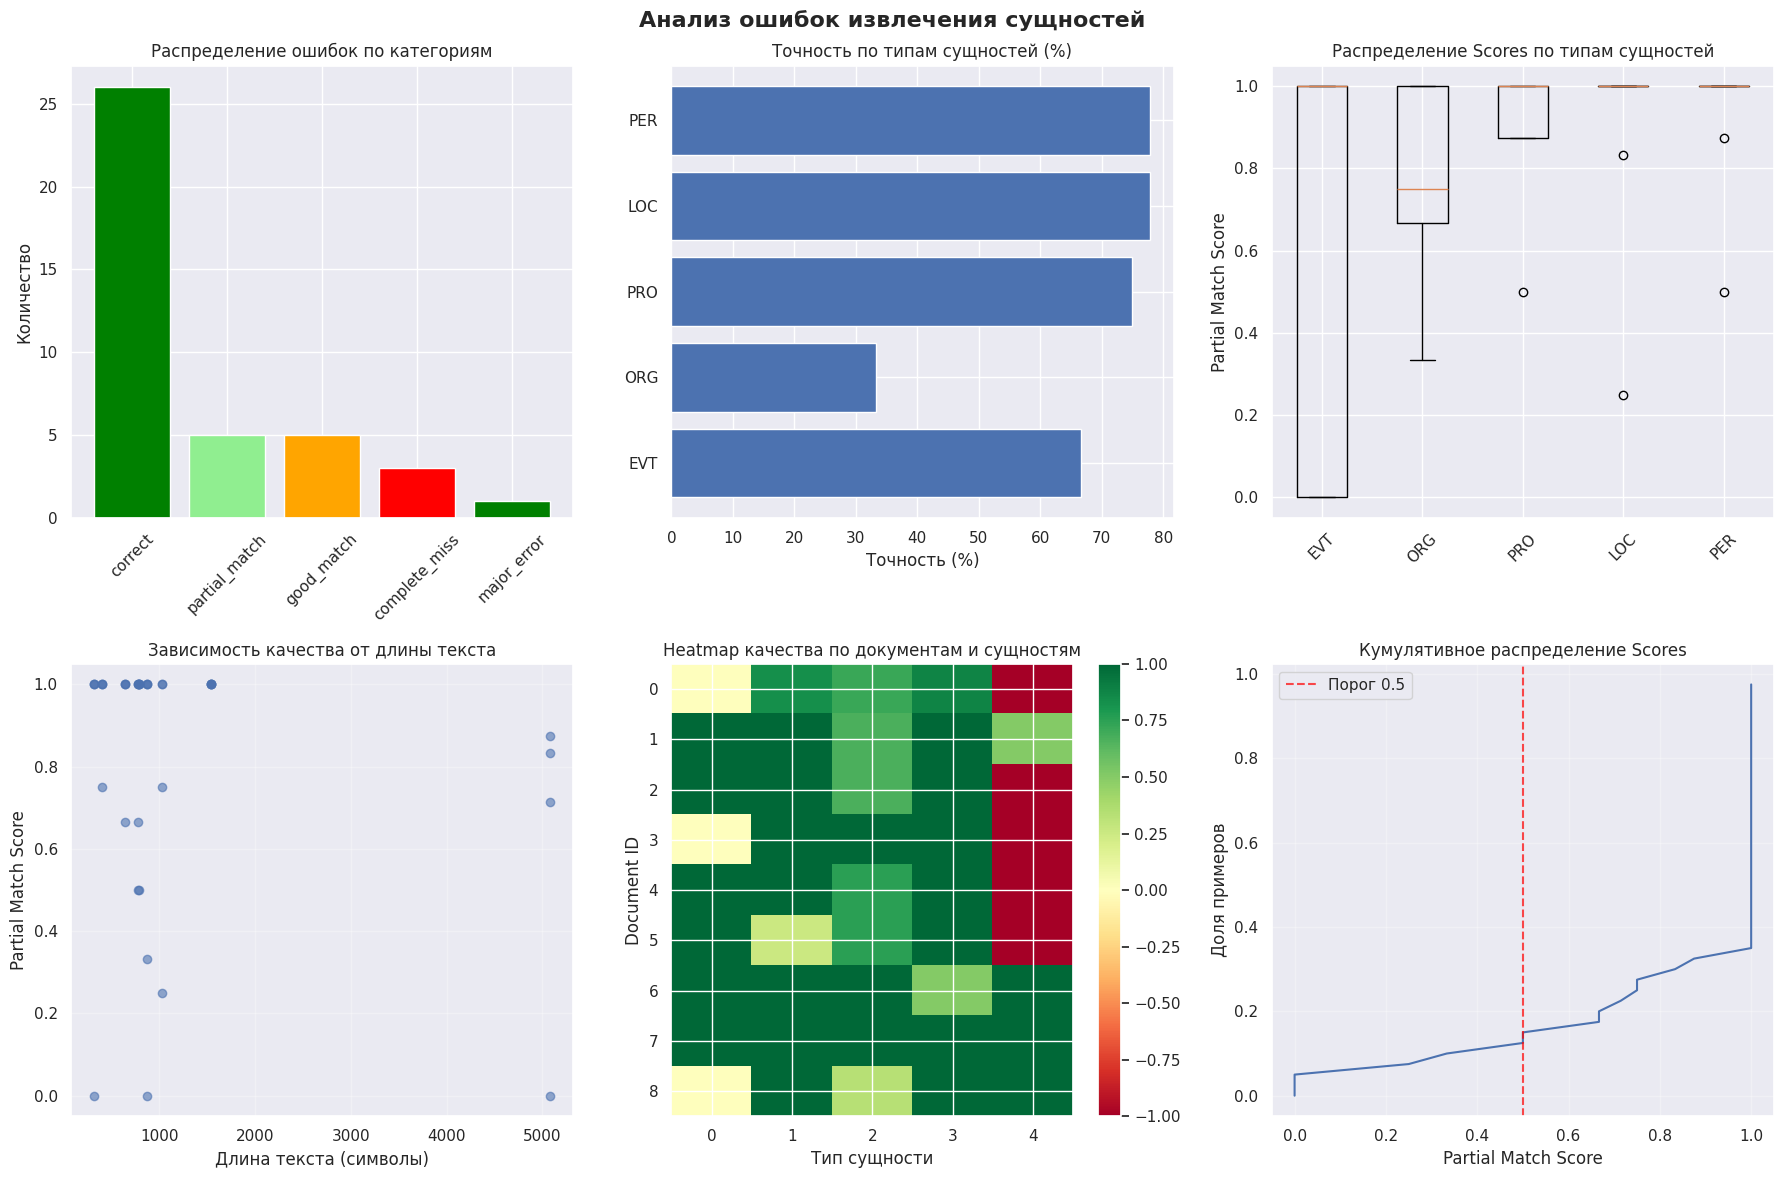


Предложение рекомендаций по улучшению метрик
--------------------------------------------------
Сущности типа 'EVT' имеют низкую точность (66.7%)
- Попробовать улучшить промпты для извлечения EVT
- Добавить примеры для EVT в few-shot learning
Сущности типа 'ORG' имеют низкую точность (33.3%)
- Попробовать улучшить промпты для извлечения ORG
- Добавить примеры для ORG в few-shot learning
Сущности типа 'PRO' имеют низкую точность (75.0%)
- Попробовать улучшить промпты для извлечения PRO
- Добавить примеры для PRO в few-shot learning


In [75]:
# Запустим анализ ошибок
analysis_df = analyze_errors(dffffff_with_scores)
# Запустим и посмотрим анализ паттернов ошибок
error_stats, entity_error_rates = analyze_error_patterns(analysis_df)
# Проведем анализ конкретных ошибок
complete_misses, partial_matches = analyze_specific_errors(analysis_df)
# На анализ успешных случаев тоже в данном случае важно глянуть
success_cases, good_cases = analyze_success_cases(analysis_df)
# Проведем анализ текстовых паттернов заодно
error_cases, success_cases = analyze_text_patterns(analysis_df)
# Теперь на графиках все рассмотрим
create_error_visualizations(analysis_df, error_stats, entity_error_rates)
# Некоторые рекомендации по улучшению исходя из анализа
provide_improvement_recommendations(analysis_df, error_stats, entity_error_rates)
# Сохраняем результаты анализа
# analysis_df.to_csv('error_analysis_results.csv', index=False, encoding='utf-8')

Исходя из анализа, видно что 65% отмечаются правильными:

Анализ ошибок по категориям

- correct        :  26 ( 65.0%)
- partial_match  :   5 ( 12.5%)
- good_match     :   5 ( 12.5%)
- complete_miss  :   3 (  7.5%)
- major_error    :   1 (  2.5%)

Хуже всего модель определяет сущности типа ORG **(3/9 (33.3%))** из-за лексикографических различий при проверке соответствия. НО это можно улучшить, исходя из возможных рекомендаций ниже.

**Рекомендации по улучшению метрик**
* Сущности типа 'ORG' имеют самую низкую точность (33.3%)
  - Попробовать улучшить промпты для извлечения ORG
  - Добавить больше примеров для ORG в few-shot learning
* Сущности типа 'EVT' имеют низкую точность (66.7%)
  - Попробовать улучшить промпты для извлечения EVT
  - Добавить больше примеров для EVT в few-shot learning


**Общие стратегии улучшения:**
1. **Улучшение промптов:**
   - Добавить больше примеров для сложных сущностей
   - Уточнить определения типов сущностей
   - Добавить обработку грамматических падежей
2. **Пост-обработка:**
   - Более хорошая нормализация текста (регистр, пробелы)
   - Точная фильтрация дубликатов (я использовал встроенную в pandas)
   - Добавить проверку границ сущностей, чтобы повысить точность и ускорить работу
3. **Альтернативные подходы:**
   - Ансамблирование с другими моделями
   - Использование специализированных NER моделей
4. **Мониторинг:**
   - Проведение A/B тестирования промптов
   - Отслеживание метрик по типам сущностей

**Возможные технические улучшения:**
- Добавить сложные синонимы для частых сущностей в промпты
- Реализовать проверку контекста вокруг сущностей
- Добавить детальную обработку составных сущностей (например, Тереза Мэй или Т. Мэй)
- Улучшить обработку аббревиатур и их расшифровок
- Добавить географический контекст для сущностей типа LOC
- Учесть организационную иерархию для сущностей типа ORG

In [76]:
analysis_df.to_csv('error_analysis_results.csv', index=False, encoding='utf-8')

### Задание 9
Сделайте выводы по всему исследованию. Напишите, чему научились и что нового попробовали.


### ОТЧЕТ ПО ИССЛЕДОВАНИЮ NER

Для меня это исследование стало первым практическим опытом работы с задачей извлечения именованных сущностей (NER). Не имея предыдущего опыта в этой области, я успешно применил свои базовые знания и самостоятельно освоил необходимые методы.

**Чему научился:**
- Анализ и подготовка текстовых данных для NLP
- Работа с разноформатными датасетами
- Промпт-инжиниринг для LLM
- Разработка кастомных метрик оценки

**Результаты**:
1. **Качество модели:**
   - Средний Partial Match Score: **0.821**
   - Лучшая точность (PER): **93.1%**
   - Наибольшие сложности (ORG): **33.3%**

2. **Метрики:**
   - Успешно реализованы Jaccard Similarity и Partial Match Score
   - Partial Match показала значительное преимущество
   - Метрики учитывают специфику задачи NER

3. **Анализ ошибок:**
   - **65%** полных совпадений
   - **7.5%** полных промахов
   - Выявлены проблемные типы сущностей

4. **Зависимости:**
   - Обнаружена отрицательная корреляция с длиной документа
   - Короткие документы обрабатываются лучше

**Технические достижения:**
- Создан пайплайн обработки данных
- Реализована система промпт-инжиниринга
- Разработаны векторизованные метрики
- Построена система анализа ошибок
- Созданы комплексные визуализации

**Перспективы развития:**
- Улучшение промптов для ORG и EVT сущностей
- Реализация продвинутой пост-обработки
- Добавление обработки синонимов
- Внедрение ансамблирования моделей

**Вывод:**
Это исследование позволило мне погрузиться в NLP и получить бесценный практический опыт. Я надеюсь, что продемонстрировал способность быстро осваивать новые технологии и решать сложные задачи, что делает меня перспективным кандидатом для стажировки в области Data Science. Исследование показало, насколько интересным может быть NLP и продемонстрировало мою усидчивость и заинтересованность при решении сложных задач.